# Digital Image Processing Functions: JPEG Compression

References:

[1] https://en.wikipedia.org/wiki/JPEG_File_Interchange_Format

[2] https://yasoob.me/posts/understanding-and-writing-jpeg-decoder-in-python/

**Requirements**: The requirements of each assignment of this course at least include a) full document in PDF/Word format with implementation details and difficulties you met, 2) source code and the compiled file (in exe/dmg/sh) and its readme to indicate how to lunch it, and 3) key comments in your source code. If your code was referred from an existing source on the Internet, please cite it accordingly.

## 0.Image Reading

In [ ]:
!pip install rawpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 45.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import rawpy
import cv2
from matplotlib import pyplot as plt
import matplotlib.pyplot as pyplot
import ipywidgets as widgets
import scipy as sp
import imageio
from skimage import io
from PIL import Image

array([[156, 157, 160, ..., 152, 152, 152],
       [156, 157, 159, ..., 152, 152, 152],
       [158, 157, 156, ..., 152, 152, 152],
       ...,
       [121, 123, 126, ..., 121, 113, 111],
       [121, 123, 126, ..., 121, 113, 111],
       [121, 123, 126, ..., 121, 113, 111]], dtype=uint8)

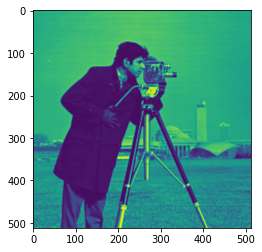

In [ ]:
from PIL import Image

# Open image
img = Image.open('/content/cameraman.tif')

# Display image
pyplot.imshow(img)

# Get image data
image_data = np.array(img)

image_data

In [ ]:
# Convert the image data to a NumPy array
image_data = np.asarray(img)

# Get the shape of the image data
image_shape = image_data.shape

# Print the image shape
print(f'Image shape: {image_shape}')

Image shape: (512, 512)


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install libtiff

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.0/130.0 KB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for libtiff: filename=libtiff-0.4.2-cp38-cp38-linux_x86_64.whl size=284367 sha256=3ffbe278de98686baf74ba2b770840743cb3fc637661df43c3be784e40b7e664
  Stored in directory: /root/.cache/pip/wheels/70/ef/75/99ce530b01b6a5bef81ebed8c05bd7713ca298e21b5635dbac
Successfully built libtiff


In [ ]:
import os
from PIL import Image

# Set the directory containing the TIFF images
input_dir = '/content/gdrive/MyDrive/DIP_A4_tif'

# Set the directory for the output PNG images
output_dir = '/content/gdrive/MyDrive/DIP_A4_png'

# Get a list of all TIFF images in the input directory
tiff_files = [f for f in os.listdir(input_dir) if f.endswith('.tif')]

# Loop through the TIFF images
for tiff_file in tiff_files:
    
    tif = TIFF.open(tiff_file) # open tiff file in read mode
    # read an image in the current TIFF directory as a numpy array
    image = tif.read_image()

    # Convert the TIFF image to a NumPy array
    image_array = np.array(image)

    # Convert the NumPy array to a Pillow image
    pil_im = Image.fromarray(image_array)

    # Save the Pillow image as a PNG file
    cv2.imwrite('{}.jpg'.format(tiff_file), image_array)

##  **1. Grey level JPEG compression**
Implement the grey level JPEG compression algorithm with your own “encode” and “decoder”. Please calculate the “RMSE and “PSNR” between the decompressed and original images, and show two examples in the report.


###utils

In [ ]:
import numpy as np


def load_quantization_table(component):
    if component == 'lum':
        q = np.array([[2, 2, 2, 2, 3, 4, 5, 6],
                      [2, 2, 2, 2, 3, 4, 5, 6],
                      [2, 2, 2, 2, 4, 5, 7, 9],
                      [2, 2, 2, 4, 5, 7, 9, 12],
                      [3, 3, 4, 5, 8, 10, 12, 12],
                      [4, 4, 5, 7, 10, 12, 12, 12],
                      [5, 5, 7, 9, 12, 12, 12, 12],
                      [6, 6, 9, 12, 12, 12, 12, 12]])
    elif component == 'chrom':
        q = np.array([[3, 3, 5, 9, 13, 15, 15, 15],
                      [3, 4, 6, 11, 14, 12, 12, 12],
                      [5, 6, 9, 14, 12, 12, 12, 12],
                      [9, 11, 14, 12, 12, 12, 12, 12],
                      [13, 14, 12, 12, 12, 12, 12, 12],
                      [15, 12, 12, 12, 12, 12, 12, 12],
                      [15, 12, 12, 12, 12, 12, 12, 12],
                      [15, 12, 12, 12, 12, 12, 12, 12]])
    else:
        raise ValueError((
            "component should be either 'lum' or 'chrom', "
            "but '{comp}' was found").format(comp=component))

    return q


def zigzag_points(rows, cols):
    # constants for directions
    UP, DOWN, RIGHT, LEFT, UP_RIGHT, DOWN_LEFT = range(6)

    # move the point in different directions
    def move(direction, point):
        return {
            UP: lambda point: (point[0] - 1, point[1]),
            DOWN: lambda point: (point[0] + 1, point[1]),
            LEFT: lambda point: (point[0], point[1] - 1),
            RIGHT: lambda point: (point[0], point[1] + 1),
            UP_RIGHT: lambda point: move(UP, move(RIGHT, point)),
            DOWN_LEFT: lambda point: move(DOWN, move(LEFT, point))
        }[direction](point)

    # return true if point is inside the block bounds
    def inbounds(point):
        return 0 <= point[0] < rows and 0 <= point[1] < cols

    # start in the top-left cell
    point = (0, 0)

    # True when moving up-right, False when moving down-left
    move_up = True

    for i in range(rows * cols):
        yield point
        if move_up:
            if inbounds(move(UP_RIGHT, point)):
                point = move(UP_RIGHT, point)
            else:
                move_up = False
                if inbounds(move(RIGHT, point)):
                    point = move(RIGHT, point)
                else:
                    point = move(DOWN, point)
        else:
            if inbounds(move(DOWN_LEFT, point)):
                point = move(DOWN_LEFT, point)
            else:
                move_up = True
                if inbounds(move(DOWN, point)):
                    point = move(DOWN, point)
                else:
                    point = move(RIGHT, point)


def bits_required(n):
    n = abs(n)
    result = 0
    while n > 0:
        n >>= 1
        result += 1
    return result


def binstr_flip(binstr):
    # check if binstr is a binary string
    if not set(binstr).issubset('01'):
        raise ValueError("binstr should have only '0's and '1's")
    return ''.join(map(lambda c: '0' if c == '1' else '1', binstr))


def uint_to_binstr(number, size):
    return bin(number)[2:][-size:].zfill(size)


def int_to_binstr(n):
    if n == 0:
        return ''

    binstr = bin(abs(n))[2:]

    # change every 0 to 1 and vice verse when n is negative
    return binstr if n > 0 else binstr_flip(binstr)


def flatten(lst):
    return [item for sublist in lst for item in sublist]

###Huffman

In [ ]:
from queue import PriorityQueue


class HuffmanTree:

    class __Node:
        def __init__(self, value, freq, left_child, right_child):
            self.value = value
            self.freq = freq
            self.left_child = left_child
            self.right_child = right_child

        @classmethod
        def init_leaf(self, value, freq):
            return self(value, freq, None, None)

        @classmethod
        def init_node(self, left_child, right_child):
            freq = left_child.freq + right_child.freq
            return self(None, freq, left_child, right_child)

        def is_leaf(self):
            return self.value is not None

        def __eq__(self, other):
            stup = self.value, self.freq, self.left_child, self.right_child
            otup = other.value, other.freq, other.left_child, other.right_child
            return stup == otup

        def __nq__(self, other):
            return not (self == other)

        def __lt__(self, other):
            return self.freq < other.freq

        def __le__(self, other):
            return self.freq < other.freq or self.freq == other.freq

        def __gt__(self, other):
            return not (self <= other)

        def __ge__(self, other):
            return not (self < other)

    def __init__(self, arr):
        q = PriorityQueue()

        # calculate frequencies and insert them into a priority queue
        for val, freq in self.__calc_freq(arr).items():
            q.put(self.__Node.init_leaf(val, freq))

        while q.qsize() >= 2:
            u = q.get()
            v = q.get()

            q.put(self.__Node.init_node(u, v))

        self.__root = q.get()

        # dictionaries to store huffman table
        self.__value_to_bitstring = dict()

    def value_to_bitstring_table(self):
        if len(self.__value_to_bitstring.keys()) == 0:
            self.__create_huffman_table()
        return self.__value_to_bitstring

    def __create_huffman_table(self):
        def tree_traverse(current_node, bitstring=''):
            if current_node is None:
                return
            if current_node.is_leaf():
                self.__value_to_bitstring[current_node.value] = bitstring
                return
            tree_traverse(current_node.left_child, bitstring + '0')
            tree_traverse(current_node.right_child, bitstring + '1')

        tree_traverse(self.__root)

    def __calc_freq(self, arr):
        freq_dict = dict()
        for elem in arr:
            if elem in freq_dict:
                freq_dict[elem] += 1
            else:
                freq_dict[elem] = 1
        return freq_dict

###encoder

In [ ]:
import os
import math
import numpy as np
from scipy import fftpack
from PIL import Image


def quantize(block, component):
    q = load_quantization_table(component)
    return (block / q).round().astype(np.int32)


def block_to_zigzag(block):
    return np.array([block[point] for point in zigzag_points(*block.shape)])


def dct_2d(image):
    return fftpack.dct(fftpack.dct(image.T, norm='ortho').T, norm='ortho')


def run_length_encode(arr):
    # determine where the sequence is ending prematurely
    last_nonzero = -1
    for i, elem in enumerate(arr):
        if elem != 0:
            last_nonzero = i

    # each symbol is a (RUNLENGTH, SIZE) tuple
    symbols = []

    # values are binary representations of array elements using SIZE bits
    values = []

    run_length = 0

    for i, elem in enumerate(arr):
        if i > last_nonzero:
            symbols.append((0, 0))
            values.append(int_to_binstr(0))
            break
        elif elem == 0 and run_length < 15:
            run_length += 1
        else:
            size = bits_required(elem)
            symbols.append((run_length, size))
            values.append(int_to_binstr(elem))
            run_length = 0
    return symbols, values


def write_to_file(filepath, dc, ac, blocks_count, tables):
    try:
        f = open(filepath, 'w')
    except FileNotFoundError as e:
        raise FileNotFoundError(
                "No such directory: {}".format(
                    os.path.dirname(filepath))) from e

    for table_name in ['dc_y', 'ac_y', 'dc_c', 'ac_c']:

        # 16 bits for 'table_size'
        f.write(uint_to_binstr(len(tables[table_name]), 16))

        for key, value in tables[table_name].items():
            if table_name in {'dc_y', 'dc_c'}:
                # 4 bits for the 'category'
                # 4 bits for 'code_length'
                # 'code_length' bits for 'huffman_code'
                f.write(uint_to_binstr(key, 4))
                f.write(uint_to_binstr(len(value), 4))
                f.write(value)
            else:
                # 4 bits for 'run_length'
                # 4 bits for 'size'
                # 8 bits for 'code_length'
                # 'code_length' bits for 'huffman_code'
                f.write(uint_to_binstr(key[0], 4))
                f.write(uint_to_binstr(key[1], 4))
                f.write(uint_to_binstr(len(value), 8))
                f.write(value)

    # 32 bits for 'blocks_count'
    f.write(uint_to_binstr(blocks_count, 32))

    for b in range(blocks_count):
        for c in range(3):
            category = bits_required(dc[b, c])
            symbols, values = run_length_encode(ac[b, :, c])

            dc_table = tables['dc_y'] if c == 0 else tables['dc_c']
            ac_table = tables['ac_y'] if c == 0 else tables['ac_c']

            f.write(dc_table[category])
            f.write(int_to_binstr(dc[b, c]))

            for i in range(len(symbols)):
                f.write(ac_table[tuple(symbols[i])])
                f.write(values[i])
    f.close()


def encoder(input_file,output_file):

    image = Image.open(input_file)
    ycbcr = image.convert('YCbCr')

    npmat = np.array(ycbcr, dtype=np.uint8)

    rows, cols = npmat.shape[0], npmat.shape[1]

    # block size: 8x8
    if rows % 8 == cols % 8 == 0:
        blocks_count = rows // 8 * cols // 8
    else:
        raise ValueError(("the width and height of the image "
                          "should both be mutiples of 8"))

    # dc is the top-left cell of the block, ac are all the other cells
    dc = np.empty((blocks_count, 3), dtype=np.int32)
    ac = np.empty((blocks_count, 63, 3), dtype=np.int32)

    for i in range(0, rows, 8):
        for j in range(0, cols, 8):
            try:
                block_index += 1
            except NameError:
                block_index = 0

            for k in range(3):
                # split 8x8 block and center the data range on zero
                # [0, 255] --> [-128, 127]
                block = npmat[i:i+8, j:j+8, k] - 128

                dct_matrix = dct_2d(block)
                quant_matrix = quantize(dct_matrix,
                                        'lum' if k == 0 else 'chrom')
                zz = block_to_zigzag(quant_matrix)

                dc[block_index, k] = zz[0]
                ac[block_index, :, k] = zz[1:]

    H_DC_Y = HuffmanTree(np.vectorize(bits_required)(dc[:, 0]))
    H_DC_C = HuffmanTree(np.vectorize(bits_required)(dc[:, 1:].flat))
    H_AC_Y = HuffmanTree(
            flatten(run_length_encode(ac[i, :, 0])[0]
                    for i in range(blocks_count)))
    H_AC_C = HuffmanTree(
            flatten(run_length_encode(ac[i, :, j])[0]
                    for i in range(blocks_count) for j in [1, 2]))

    tables = {'dc_y': H_DC_Y.value_to_bitstring_table(),
              'ac_y': H_AC_Y.value_to_bitstring_table(),
              'dc_c': H_DC_C.value_to_bitstring_table(),
              'ac_c': H_AC_C.value_to_bitstring_table()}

    write_to_file(output_file, dc, ac, blocks_count, tables)    

###decoder

In [ ]:
from numpy.core.memmap import dtype
import argparse
import math
import numpy as np
from scipy import fftpack
from PIL import Image


class JPEGFileReader:
    TABLE_SIZE_BITS = 16
    BLOCKS_COUNT_BITS = 32

    DC_CODE_LENGTH_BITS = 4
    CATEGORY_BITS = 4

    AC_CODE_LENGTH_BITS = 8
    RUN_LENGTH_BITS = 4
    SIZE_BITS = 4

    def __init__(self, filepath):
        self.__file = open(filepath, 'r')

    def read_int(self, size):
        if size == 0:
            return 0

        # the most significant bit indicates the sign of the number
        bin_num = self.__read_str(size)
        if bin_num[0] == '1':
            return self.__int2(bin_num)
        else:
            return self.__int2(binstr_flip(bin_num)) * -1

    def read_dc_table(self):
        table = dict()

        table_size = self.__read_uint(self.TABLE_SIZE_BITS)
        for _ in range(table_size):
            category = self.__read_uint(self.CATEGORY_BITS)
            code_length = self.__read_uint(self.DC_CODE_LENGTH_BITS)
            code = self.__read_str(code_length)
            table[code] = category
        return table

    def read_ac_table(self):
        table = dict()

        table_size = self.__read_uint(self.TABLE_SIZE_BITS)
        for _ in range(table_size):
            run_length = self.__read_uint(self.RUN_LENGTH_BITS)
            size = self.__read_uint(self.SIZE_BITS)
            code_length = self.__read_uint(self.AC_CODE_LENGTH_BITS)
            code = self.__read_str(code_length)
            table[code] = (run_length, size)
        return table

    def read_blocks_count(self):
        return self.__read_uint(self.BLOCKS_COUNT_BITS)

    def read_huffman_code(self, table):
        prefix = ''
        # TODO: break the loop if __read_char is not returing new char
        while prefix not in table:
            prefix += self.__read_char()
        return table[prefix]

    def __read_uint(self, size):
        if size <= 0:
            raise ValueError("size of unsigned int should be greater than 0")
        return self.__int2(self.__read_str(size))

    def __read_str(self, length):
        return self.__file.read(length)

    def __read_char(self):
        return self.__read_str(1)

    def __int2(self, bin_num):
        return int(bin_num, 2)


def read_image_file(filepath):
    reader = JPEGFileReader(filepath)

    tables = dict()
    for table_name in ['dc_y', 'ac_y', 'dc_c', 'ac_c']:
        if 'dc' in table_name:
            tables[table_name] = reader.read_dc_table()
        else:
            tables[table_name] = reader.read_ac_table()

    blocks_count = reader.read_blocks_count()

    dc = np.empty((blocks_count, 3), dtype=np.int32)
    ac = np.empty((blocks_count, 63, 3), dtype=np.int32)

    for block_index in range(blocks_count):
        for component in range(3):
            dc_table = tables['dc_y'] if component == 0 else tables['dc_c']
            ac_table = tables['ac_y'] if component == 0 else tables['ac_c']

            category = reader.read_huffman_code(dc_table)
            dc[block_index, component] = reader.read_int(category)

            cells_count = 0

            # TODO: try to make reading AC coefficients better
            while cells_count < 63:
                run_length, size = reader.read_huffman_code(ac_table)

                if (run_length, size) == (0, 0):
                    while cells_count < 63:
                        ac[block_index, cells_count, component] = 0
                        cells_count += 1
                else:
                    for i in range(run_length):
                        ac[block_index, cells_count, component] = 0
                        cells_count += 1
                    if size == 0:
                        ac[block_index, cells_count, component] = 0
                    else:
                        value = reader.read_int(size)
                        ac[block_index, cells_count, component] = value
                    cells_count += 1

    return dc, ac, tables, blocks_count


def zigzag_to_block(zigzag):
    # assuming that the width and the height of the block are equal
    rows = cols = int(math.sqrt(len(zigzag)))

    if rows * cols != len(zigzag):
        raise ValueError("length of zigzag should be a perfect square")

    block = np.empty((rows, cols), np.int32)

    for i, point in enumerate(zigzag_points(rows, cols)):
        block[point] = zigzag[i]

    return block


def dequantize(block, component):
    q = load_quantization_table(component)
    return block * q


def idct_2d(image):
    return fftpack.idct(fftpack.idct(image.T, norm='ortho').T, norm='ortho')


def decoder(filepath):
    
    dc, ac, tables, blocks_count = read_image_file(filepath)

    # assuming that the block is a 8x8 square
    block_side = 8

    # assuming that the image height and width are equal
    image_side = int(math.sqrt(blocks_count)) * block_side

    blocks_per_line = image_side // block_side

    npmat = np.empty((image_side, image_side, 3), dtype='uint8')

    for block_index in range(blocks_count):
        i = block_index // blocks_per_line * block_side
        j = block_index % blocks_per_line * block_side

        for c in range(3):
            zigzag = [dc[block_index, c]] + list(ac[block_index, :, c])
            quant_matrix = zigzag_to_block(zigzag)
            dct_matrix = dequantize(quant_matrix, 'lum' if c == 0 else 'chrom')
            block = idct_2d(dct_matrix)
            npmat[i:i+8, j:j+8, c] = block + 128

    image = Image.fromarray(npmat, 'YCbCr')
    image = image.convert('RGB')
    imageio.imwrite('/content/'+str(name)+'_decoder_bitstream.png', image)

###Calculate the “RMSE and “PSNR” between the decompressed and original images

In [ ]:
def rmse(image1, image2):
  # Calculate RMSE between two images
  mse = np.square(np.subtract(image1, image2)).mean()
  rmse = math.sqrt(mse)
  return rmse

def psnr(image1, image2):
  # Calculate PSNR between two images
  mse = np.square(np.subtract(image1, image2)).mean()
  psnr = 10 * math.log10(255**2 / mse)
  return psnr

--------cameraman.tif_encoder_bitstream is done.--------


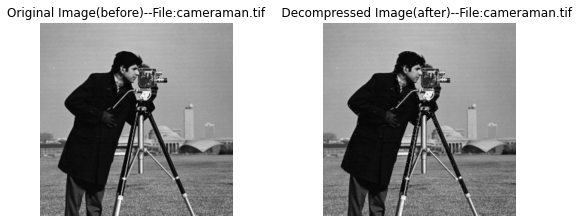

----File:cameraman.tif----RMSE: 1.451274390726211
----File:cameraman.tif----PSNR: 44.895812973814856
   
--------house.tif_encoder_bitstream is done.--------


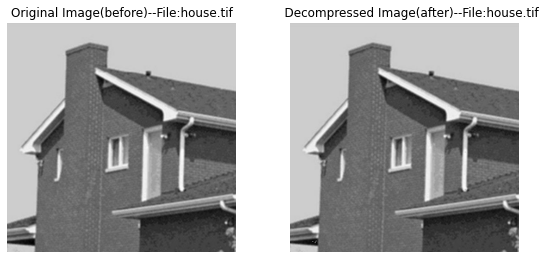

----File:house.tif----RMSE: 1.0559689119560187
----File:house.tif----PSNR: 47.65778095617578
   
--------jetplane.tif_encoder_bitstream is done.--------


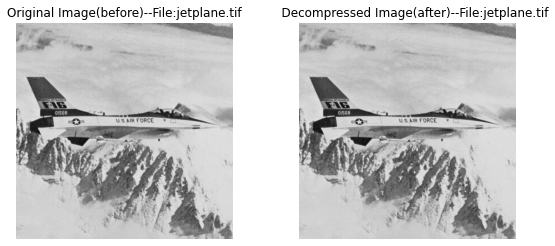

----File:jetplane.tif----RMSE: 1.347635020213217
----File:jetplane.tif----PSNR: 45.539357844365384
   
--------lake.tif_encoder_bitstream is done.--------


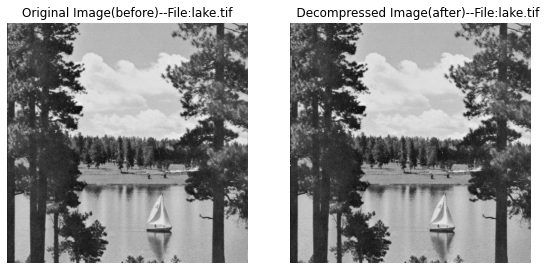

----File:lake.tif----RMSE: 1.5240946599442906
----File:lake.tif----PSNR: 44.470564780224564
   
--------lena_color_512.tif_encoder_bitstream is done.--------


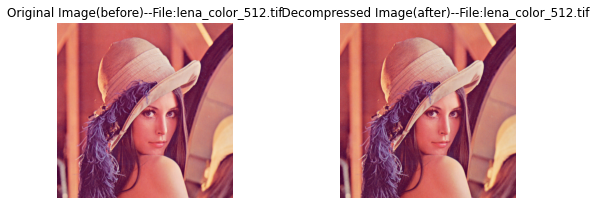

----File:lena_color_512.tif----RMSE: 3.674019867515388
----File:lena_color_512.tif----PSNR: 36.82797359961008
   
--------lena_gray_512.tif_encoder_bitstream is done.--------


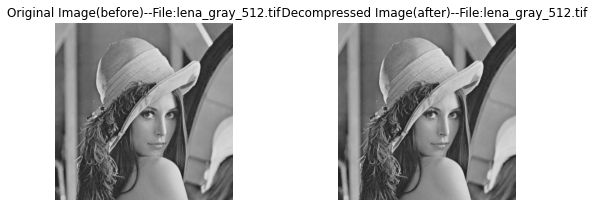

----File:lena_gray_512.tif----RMSE: 1.3897853416619552
----File:lena_gray_512.tif----PSNR: 45.27184907310559
   
--------livingroom.tif_encoder_bitstream is done.--------


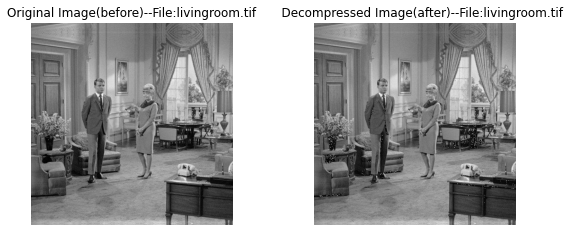

----File:livingroom.tif----RMSE: 1.7587595105269909
----File:livingroom.tif----PSNR: 43.2266744305753
   
--------mandril_color.tif_encoder_bitstream is done.--------


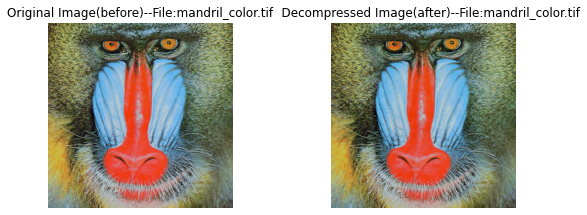

----File:mandril_color.tif----RMSE: 5.053604285056177
----File:mandril_color.tif----PSNR: 34.05877896600328
   
--------mandril_gray.tif_encoder_bitstream is done.--------


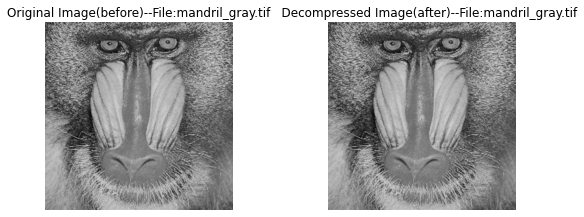

----File:mandril_gray.tif----RMSE: 1.9429912889474779
----File:mandril_gray.tif----PSNR: 42.36138653822255
   
--------peppers_color.tif_encoder_bitstream is done.--------


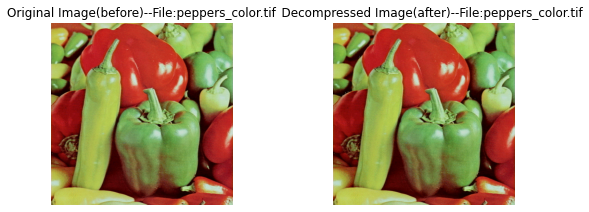

----File:peppers_color.tif----RMSE: 3.969858570414291
----File:peppers_color.tif----PSNR: 36.155302910105696
   
--------peppers_gray.tif_encoder_bitstream is done.--------


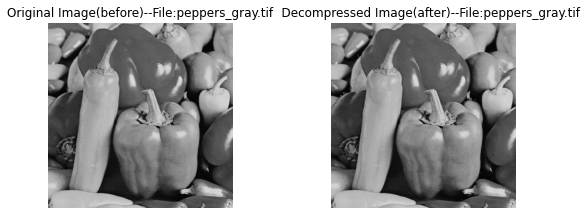

----File:peppers_gray.tif----RMSE: 1.3546720686476925
----File:peppers_gray.tif----PSNR: 45.494120081051065
   
--------pirate.tif_encoder_bitstream is done.--------


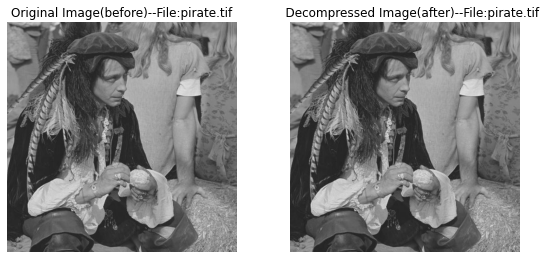

----File:pirate.tif----RMSE: 1.6023114197890271
----File:pirate.tif----PSNR: 44.03586504972074
   
--------walkbridge.tif_encoder_bitstream is done.--------


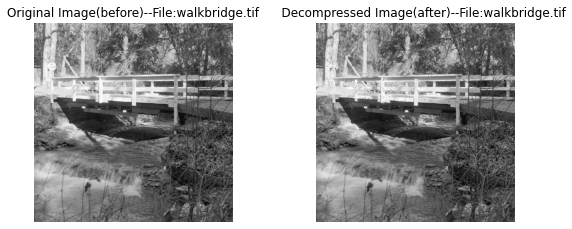

----File:walkbridge.tif----RMSE: 1.8515944337304227
----File:walkbridge.tif----PSNR: 42.7798862779758
   
--------woman_blonde.tif_encoder_bitstream is done.--------


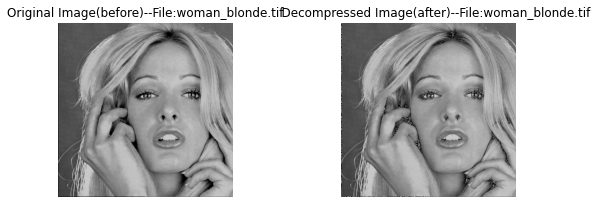

----File:woman_blonde.tif----RMSE: 1.52131888942788
----File:woman_blonde.tif----PSNR: 44.486398454470645
   
--------woman_darkhair.tif_encoder_bitstream is done.--------


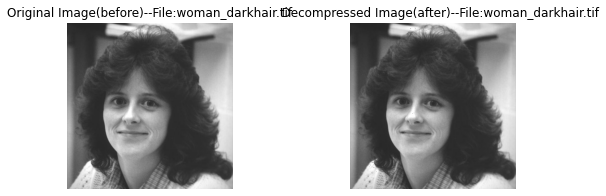

----File:woman_darkhair.tif----RMSE: 1.0829157880481317
----File:woman_darkhair.tif----PSNR: 47.438909900143045
   


In [ ]:
import matplotlib

np.seterr(divide='ignore',invalid='ignore')

for name in ['cameraman.tif','house.tif','jetplane.tif', 'lake.tif', 'lena_color_512.tif', 'lena_gray_512.tif','livingroom.tif', 'mandril_color.tif', 'mandril_gray.tif','peppers_color.tif','peppers_gray.tif', 'pirate.tif', 'walkbridge.tif', 'woman_blonde.tif', 'woman_darkhair.tif']:
    matplotlib.rcParams['font.size'] = 10    
    # Read image
    im = np.array(Image.open('/{}'.format(name)).convert('RGB'), dtype = 'uint8')

    #Encoder
    encoder('/{}'.format(name),'/content/{}_encoder_bitstream'.format(name))
    print('--------{}_encoder_bitstream is done.--------'.format(name))
    
    # Decoder
    im2 = decoder('/content/'+str(name)+'_encoder_bitstream')
    
    # Specify the data type so that float value will be converted to int
    im2 = np.array(Image.open('/content/'+str(name)+'_decoder_bitstream.png'), dtype = 'uint8')
      
    fig, (ax1, ax2) = plt.subplots(nrows=1, 
                                        ncols=2, 
                                        figsize=(8, 5),
                                        sharex=True, 
                                        sharey=True)
    for aa in (ax1, ax2):
        aa.set_axis_off()
      
    # displaying images
    ax1.imshow(im)
    ax1.set_title('Original Image(before)'+'--File:'+str(name))
    ax2.imshow(im2)
    ax2.set_title('    Decompressed Image(after)'+'--File:'+str(name))
      
    plt.tight_layout()
    plt.show()


    # Calculate RMSE and PSNR
    rmse_val = rmse(im, im2)
    psnr_val = psnr(im, im2)

    print('----File:'+str(name)+'----RMSE:', rmse_val)
    print('----File:'+str(name)+'----PSNR:', psnr_val)
    print("   ")

## **2.Implement the color level JPEG compression with “4:2:0” color sampling.**


In [ ]:
import numpy as np
from scipy.fftpack import dct, idct

# JPEG quality table
jpeg_quality_table = {
  100: (1, 1, 1),
  90: (2, 2, 2),
  80: (3, 3, 3),
  70: (4, 4, 4),
  60: (5, 5, 5),
  50: (6, 6, 6),
  40: (8, 8, 8),
  30: (10, 10, 10),
  20: (12, 12, 12),
  10: (15, 15, 15),
}

def jpeg_compress(image, quality):
  # Convert the image to YCbCr color space
  image = image.convert('YCbCr')

  # Split the image into Y, Cb, and Cr channels
  Y, Cb, Cr = image.split()

  # Downsample the Cb and Cr channels
  Cb = Cb.resize((Cb.size[0]//2, Cb.size[1]//2), resample=Image.BICUBIC)
  Cr = Cr.resize((Cr.size[0]//2, Cr.size[1]//2), resample=Image.BICUBIC)

  # Perform the DCT on the Y channel
  Y_dct = dct(dct(Y, axis=0, norm='ortho'), axis=1, norm='ortho')
  Cb_dct = dct(dct(Cb, axis=0, norm='ortho'), axis=1, norm='ortho')
  Cr_dct = dct(dct(Cr, axis=0, norm='ortho'), axis=1, norm='ortho')

  # Quantize the DCT coefficients
  Y_dct = np.round(Y_dct / jpeg_quality_table[quality][0]) * jpeg_quality_table[quality][0]
  Cb_dct = np.round(Cb_dct / jpeg_quality_table[quality][1]) * jpeg_quality_table[quality][1]
  Cr_dct = np.round(Cr_dct / jpeg_quality_table[quality][2]) * jpeg_quality_table[quality][2]

  # Perform the inverse DCT on the quantized coefficients
  Y = idct(idct(Y_dct, axis=0, norm='ortho'), axis=1, norm='ortho')
  Cb = idct(idct(Cb_dct, axis=0, norm='ortho'), axis=1, norm='ortho')
  Cr = idct(idct(Cr_dct, axis=0, norm='ortho'), axis=1, norm='ortho')

  # Convert the channels back to the RGB color space
  image = Image.merge('RGB', (Y, Cb, Cr))

  # Encode the image as a JPEG and return the bitstream
  return image.tobytes('jpeg', quality=quality)

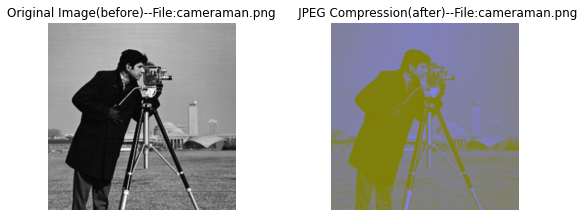

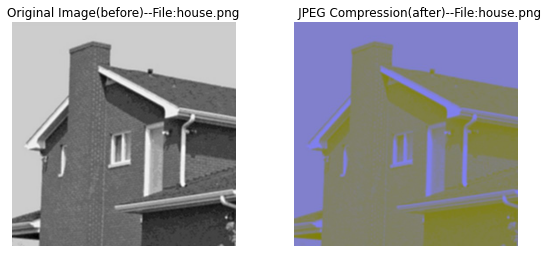

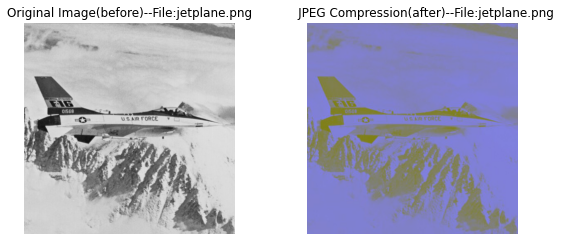

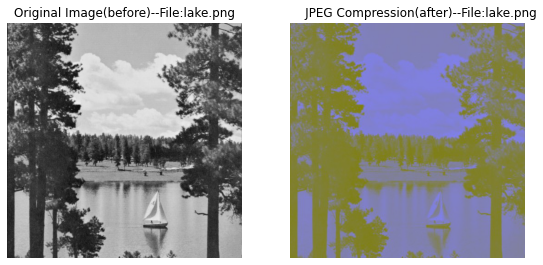

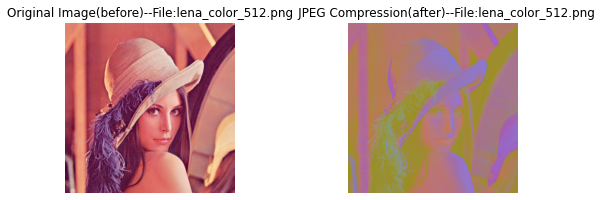

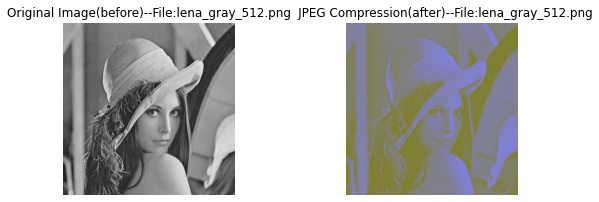

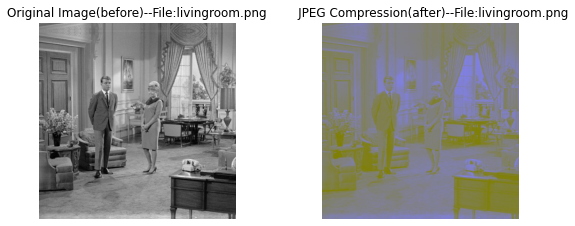

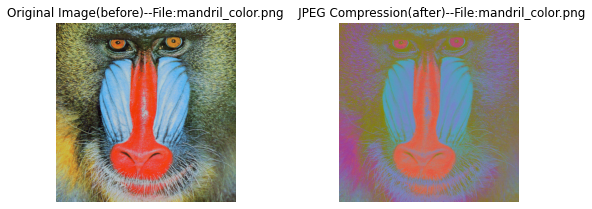

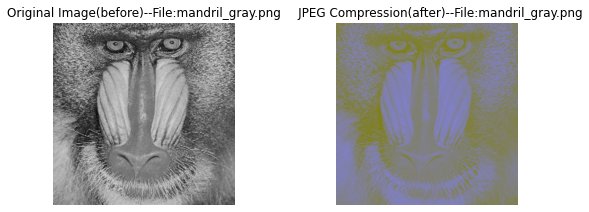

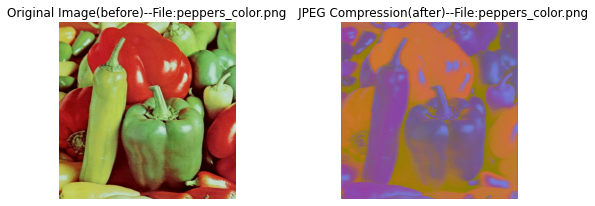

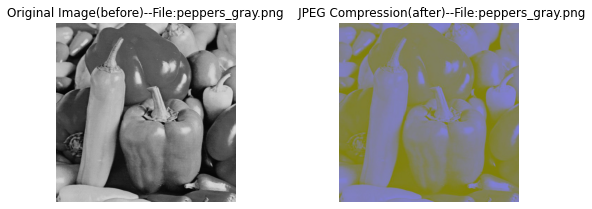

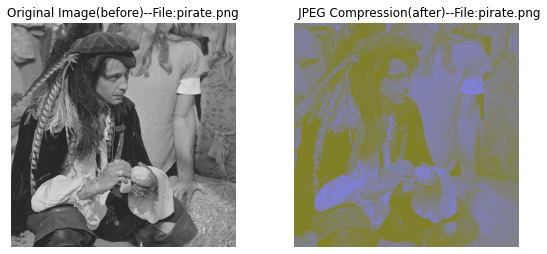

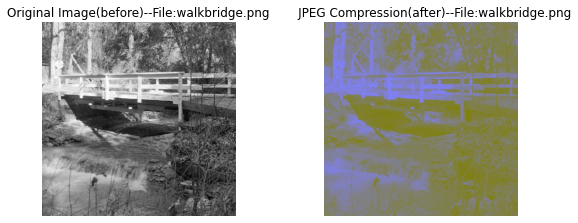

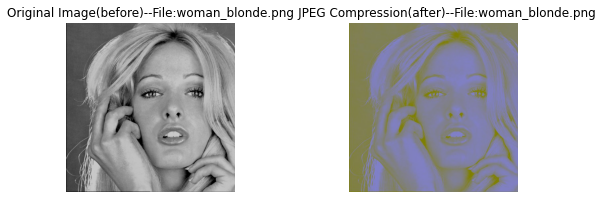

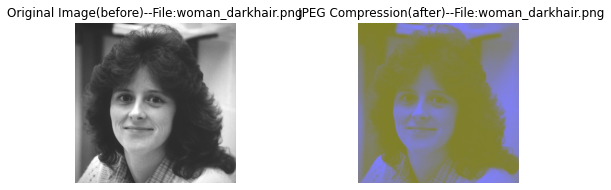

In [ ]:
import numpy as np
import cv2
import matplotlib

np.seterr(divide='ignore',invalid='ignore')


for name in ['cameraman.png','house.png','jetplane.png', 'lake.png', 'lena_color_512.png', 'lena_gray_512.png','livingroom.png', 'mandril_color.png', 'mandril_gray.png','peppers_color.png','peppers_gray.png', 'pirate.png', 'walkbridge.png', 'woman_blonde.png', 'woman_darkhair.png']:
    
    matplotlib.rcParams['font.size'] = 10    
    # Read image
    img = np.array(Image.open('/{}'.format(name)).convert('RGB'), dtype = 'uint8')

    # Convert the image to YCbCr color space
    img_ycbcr = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)

    # Downsample the chroma channels (Cb and Cr) by a factor of 2 in both horizontal and vertical directions
    img_ycbcr[:,:,1] = cv2.resize(img_ycbcr[:,:,1], (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)
    img_ycbcr[:,:,2] = cv2.resize(img_ycbcr[:,:,2], (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)

    # Encode the image using JPEG compression
    _, jpeg_data = cv2.imencode('.jpg', img_ycbcr, [cv2.IMWRITE_JPEG_QUALITY, 90])

    # Save the JPEG data to a file
    with open('/content/'+str(name)+'_color level JPEG compression.jpg', 'wb') as f:
        f.write(jpeg_data)

    # Read the color level JPEG compression Result
    im2 = np.array(Image.open('/content/'+str(name)+'_color level JPEG compression.jpg'), dtype = 'uint8')
      
    fig, (ax1, ax2) = plt.subplots(nrows=1, 
                                        ncols=2, 
                                        figsize=(8, 5),
                                        sharex=True, 
                                        sharey=True)
    for aa in (ax1, ax2):
        aa.set_axis_off()
      
    # displaying images
    ax1.imshow(img)
    ax1.set_title('Original Image(before)'+'--File:'+str(name))
    ax2.imshow(im2)
    ax2.set_title('       JPEG Compression(after)'+'--File:'+str(name))
      
    plt.tight_layout()
    plt.show()


## **3.Design a mechanism called “Quality factor” that can control the output quality by changing the quantization table dynamically.** 
Refer to http://www.robertstocker.co.uk/jpeg/jpeg_new_10.htm for more details.


In [ ]:
default_quantization_table = [[16, 11, 10, 16, 24, 40, 51, 61],
                              [12, 12, 14, 19, 26, 58, 60, 55],
                              [14, 13, 16, 24, 40, 57, 69, 56],
                              [14, 17, 22, 29, 51, 87, 80, 62],
                              [18, 22, 37, 56, 68, 109, 103, 77],
                              [24, 35, 55, 64, 81, 104, 113, 92],
                              [49, 64, 78, 87, 103, 121, 120, 101],
                              [72, 92, 95, 98, 112, 100, 103, 99]]


def get_modified_quantization_table(quality_factor):
  # Create a copy of the default quantization table
  modified_table = default_quantization_table.copy()

  # Scale the values in the table based on the quality factor
  for i in range(len(modified_table)):
    for j in range(len(modified_table[i])):
      modified_table[i][j] = modified_table[i][j] * (quality_factor / 100)

  return modified_table

In [ ]:
from struct import unpack

marker_mapping = {
    0xffd8: "Start of Image",
    0xffe0: "Application Default Header",
    0xffdb: "Quantization Table",
    0xffc0: "Start of Frame",
    0xffc4: "Define Huffman Table",
    0xffda: "Start of Scan",
    0xffd9: "End of Image"
}

class JPEG:
    def __init__(self, image_file):
        with open(image_file, 'rb') as f:
            self.img_data = f.read()
    
    def decode(self):
        data = self.img_data
        while(True):
            marker, = unpack(">H", data[0:2])
            print(marker_mapping.get(marker))
            if marker == 0xffd8:
                data = data[2:]
            elif marker == 0xffd9:
                return
            elif marker == 0xffda:
                data = data[-2:]
            else:
                lenchunk, = unpack(">H", data[2:4])
                data = data[2+lenchunk:]            
            if len(data)==0:
                break       

In [ ]:
class JPEG:
    # ...
    
    def decodeHuffman(self, data):
        offset = 0
        header, = unpack("B",data[offset:offset+1])
        offset += 1

        # Extract the 16 bytes containing length data
        lengths = unpack("BBBBBBBBBBBBBBBB", data[offset:offset+16]) 
        offset += 16

        # Extract the elements after the initial 16 bytes
        elements = []
        for i in lengths:
            elements += (unpack("B"*i, data[offset:offset+i]))
            offset += i 

        print("Header: ",header)
        print("lengths: ", lengths)
        print("Elements: ", len(elements))
        data = data[offset:]

    
    def decode(self):
        data = self.img_data
        while(True):
            # ---
            if len(data)==0:
                break 
            else:
                len_chunk, = unpack(">H", data[2:4])
                len_chunk += 2
                chunk = data[4:len_chunk]

                if marker == 0xffc4:
                    self.decodeHuffman(chunk)
                data = data[len_chunk:]            

In [ ]:
class HuffmanTable():
    def __init__(self):
        self.root=[]
        self.elements = []
    
    def BitsFromLengths(self, root, element, pos):
        if isinstance(root,list):
            if pos==0:
                if len(root)<2:
                    root.append(element)
                    return True                
                return False
            for i in [0,1]:
                if len(root) == i:
                    root.append([])
                if self.BitsFromLengths(root[i], element, pos-1) == True:
                    return True
        return False
    
    def GetHuffmanBits(self,  lengths, elements):
        self.elements = elements
        ii = 0
        for i in range(len(lengths)):
            for j in range(lengths[i]):
                self.BitsFromLengths(self.root, elements[ii], i)
                ii+=1

    def Find(self,st):
        r = self.root
        while isinstance(r, list):
            r=r[st.GetBit()]
        return  r 

    def GetCode(self, st):
        while(True):
            res = self.Find(st)
            if res == 0:
                return 0
            elif ( res != -1):
                return res
                
class JPEG:
    # -----

    def decodeHuffman(self, data):
        # ----
        hf = HuffmanTable()
        hf.GetHuffmanBits(lengths, elements)
        data = data[offset:]

In [ ]:
class Stream:
    def __init__(self, data):
        self.data= data
        self.pos = 0

    def GetBit(self):
        b = self.data[self.pos >> 3]
        s = 7-(self.pos & 0x7)
        self.pos+=1
        return (b >> s) & 1

    def GetBitN(self, l):
        val = 0
        for i in range(l):
            val = val*2 + self.GetBit()
        return val

In [ ]:
def GetArray(type,l, length):
    s = ""
    for i in range(length):
        s =s+type
    return list(unpack(s,l[:length]))
  
class JPEG:
    # ------
    def __init__(self, image_file):
        self.huffman_tables = {}
        self.quant = {}
        with open(image_file, 'rb') as f:
            self.img_data = f.read()

    def DefineQuantizationTables(self, data):
        hdr, = unpack("B",data[0:1])
        self.quant[hdr] =  GetArray("B", data[1:1+64],64)
        data = data[65:]


    def decodeHuffman(self, data):
        # ------ 
        for i in lengths:
            elements += (GetArray("B", data[off:off+i], i))
            offset += i 
            # ------

    def decode(self):
        # ------
        while(True):
            # ----
            if len(data)==0:
                break 
            else:
                # -----
                if marker == 0xffc4:
                    self.decodeHuffman(chunk)
                elif marker == 0xffdb:
                    self.DefineQuantizationTables(chunk)
                data = data[len_chunk:]            

In [ ]:

np.seterr(divide='ignore',invalid='ignore')


for name in ['cameraman.png','house.png','jetplane.png', 'lake.png', 'lena_color_512.png', 'lena_gray_512.png','livingroom.png', 'mandril_color.png', 'mandril_gray.png','peppers_color.png','peppers_gray.png', 'pirate.png', 'walkbridge.png', 'woman_blonde.png', 'woman_darkhair.png']:
    
    matplotlib.rcParams['font.size'] = 10    
    # Read image
    img = np.array(Image.open('/{}'.format(name)).convert('RGB'), dtype = 'uint8')

    # Convert the image to YCbCr color space
    img_ycbcr = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)

    # Downsample the chroma channels (Cb and Cr) by a factor of 2 in both horizontal and vertical directions
    img_ycbcr[:,:,1] = cv2.resize(img_ycbcr[:,:,1], (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)
    img_ycbcr[:,:,2] = cv2.resize(img_ycbcr[:,:,2], (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)

    
    # Get the modified quantization table based on the desired quality factor
    modified_table = get_modified_quantization_table(90)

    # Encode the image using JPEG compression with the modified quantization table
    _, jpeg_data = cv2.imencode(".jpg", img, [cv2.IMWRITE_JPEG_QUALITY, color_mode])

    # Encode the image using JPEG compression
    _, jpeg_data = cv2.imencode('.jpg', img_ycbcr, [cv2.IMWRITE_JPEG_QUALITY, 90])

    # Save the JPEG data to a file
    with open('/content/'+str(name)+'_color level JPEG compression.jpg', 'wb') as f:
        f.write(im2)

    # Read the color level JPEG compression Result
    im2 = np.array(Image.open('/content/'+str(name)+'_color level JPEG compression.jpg'), dtype = 'uint8')
      
    fig, (ax1, ax2) = plt.subplots(nrows=1, 
                                        ncols=2, 
                                        figsize=(8, 5),
                                        sharex=True, 
                                        sharey=True)
    for aa in (ax1, ax2):
        aa.set_axis_off()
      
    # displaying images
    ax1.imshow(img)
    ax1.set_title('Original Image(before)'+'--File:'+str(name))
    ax2.imshow(im2)
    ax2.set_title('       JPEG Compression(after)'+'--File:'+str(name))
      
    plt.tight_layout()
    plt.show()

NameError: ignored

## **4.Implement the full-functional JPEG compression (works with both grey and color) with the standard bitstream.**


In [ ]:
from collections import defaultdict
from typing import List, Tuple, Dict, BinaryIO


zigzag = [(0, 0), (0, 1), (1, 0), (2, 0), (1, 1), (0, 2), (0, 3), (1, 2),
          (2, 1), (3, 0), (4, 0), (3, 1), (2, 2), (1, 3), (0, 4), (0, 5),
          (1, 4), (2, 3), (3, 2), (4, 1), (5, 0), (6, 0), (5, 1), (4, 2),
          (3, 3), (2, 4), (1, 5), (0, 6), (0, 7), (1, 6), (2, 5), (3, 4),
          (4, 3), (5, 2), (6, 1), (7, 0), (7, 1), (6, 2), (5, 3), (4, 4),
          (3, 5), (2, 6), (1, 7), (2, 7), (3, 6), (4, 5), (5, 4), (6, 3),
          (7, 2), (7, 3), (6, 4), (5, 5), (4, 6), (3, 7), (4, 7), (5, 6),
          (6, 5), (7, 4), (7, 5), (6, 6), (5, 7), (6, 7), (7, 6), (7, 7)]


class HuffmanTable:
    table_class: int
    dest_id: int
    counts: List[int]
    huff_data: Dict[Tuple[int, int], int]


class QuantizationTable:
    precision: int
    dest_id: int
    table: List[List[int]]


class FrameComponent:
    identifier: int
    sampling_factor: int
    h_sampling_factor: int
    v_sampling_factor: int
    quant_table_dest: int


class StartOfFrame:
    precision: int
    num_lines: int
    samples_per_line: int
    components: List[FrameComponent]


class ScanComponent:
    selector: int
    dc_table: int
    ac_table: int


class StartOfScan:
    components: List[ScanComponent]
    spectral_selection_range: Tuple[int, int]
    successive_approximation: int


def define_huffman_table(file) -> List[HuffmanTable]:
    
    # Lh: Huffman table definition length – Specifies the length of all Huffman table parameters
    size = int.from_bytes(file.read(2), byteorder="big")

    huff_tables = []

    bytes_left = size - 2
    while bytes_left > 0:
        huff_table = HuffmanTable()
        huff_table.huff_data = {}

        table = int.from_bytes(file.read(1), byteorder="big")
        # Tc: Table class – 0 = DC table or lossless table, 1 = AC table
        huff_table.table_class = table >> 4

        # Th: Huffman table destination identifier – Specifies one of four possible destinations at the decoder into
        # which the Huffman table shall be installed
        huff_table.dest_id = table & 0b1111

        # Li: Number of Huffman codes of length i – Specifies the number of Huffman codes for each of the 16 possible
        # lengths allowed by this Specification. Li’s are the elements of the list BITS.
        huff_table.counts = [int.from_bytes(file.read(1), byteorder="big") for _ in range(16)]

        length_codes_map = defaultdict(list)
        # Incrementing code used to build Huffman map
        code = 0
        for i in range(16):
            # Go through number of codes in each length
            for j in range(huff_table.counts[i]):
                huff_byte = int.from_bytes(file.read(1), byteorder="big")
                huff_table.huff_data[(code, i+1)] = huff_byte
                length_codes_map[i+1].append(huff_byte)

                # increment code
                code += 1

            # Shift bits to left (increase length by 1)
            code <<= 1

        bytes_left -= 17 + sum(huff_table.counts)

        print(f"Huffman table length: {size}")
        print(f"Destination ID: {huff_table.dest_id}")
        print(f"Class = {huff_table.table_class} (" +
              ("DC / Lossless table" if huff_table.table_class == 0 else "AC table") + ")")

        for i in range(16):
            print(f"    Codes of length {i+1} bits ({huff_table.counts[i]} total): ", end="")
            for huff_byte in length_codes_map[i+1]:
                print(f"{huff_byte:02X} ", end="")
            print()

        print(f"Total number of codes: {sum(huff_table.counts)}")
        print()

        huff_tables.append(huff_table)

    return huff_tables


def define_quantization_table(file) -> List[QuantizationTable]:

    # Lq: Quantization table definition length – Specifies the length of all quantization table parameters
    size = int.from_bytes(file.read(2), byteorder="big")

    quant_tables = []

    bytes_left = size - 2
    while bytes_left > 0:
        quant_table = QuantizationTable()
        quant_table.table = {}

        # Create empty 8x8 table
        quant_table.table = [[0 for _ in range(8)] for _ in range(8)]

        temp = int.from_bytes(file.read(1), byteorder="big")
        # Pq: Quantization table element precision – Specifies the precision of the Qk values. Value 0 indicates 8-bit
        # Qk values; value 1 indicates 16-bit Qk values. Pq shall be zero for 8 bit sample precision P.
        quant_table.precision = temp >> 4
        element_bytes = 1 if quant_table.precision == 0 else 2

        # Tq: Quantization table destination identifier – Specifies one of four possible destinations at the decoder
        # into
        # which the quantization table shall be installed
        quant_table.dest_id = temp & 0b1111

        bytes_left -= 65 + (64 * quant_table.precision)

        for i in range(64):
            # Qk: Quantization table element – Specifies the kth element out of 64 elements, where k is the index in
            # the zigzag ordering of the DCT coefficients.
            # The quantization elements shall be specified in zig-zag scan order.
            element = int.from_bytes(file.read(element_bytes), byteorder="big")

            row, col = zigzag[i]
            quant_table.table[row][col] = element

        print(f"Quantization table length: {size}")
        print("Precision: " + ("8 bits" if quant_table.precision == 0 else "16 bits"))
        print("Destination ID: " + str(quant_table.dest_id) +
              (" (Luminance)" if quant_table.dest_id == 0 else " (Chrominance)"))
        for i in range(len(quant_table.table)):
            print(f"    DQT, Row #{i}: " + "".join(str(element).rjust(4) for element in quant_table.table[i]))
        print()

        quant_tables.append(quant_table)
    return quant_tables


def read_start_of_frame(file) -> StartOfFrame:
    sof = StartOfFrame()
    sof.components = []

    # Lf: Frame header length – Specifies the length of the frame header
    size = int.from_bytes(file.read(2), byteorder="big")

    # P: Sample precision – Specifies the precision in bits for the samples of the components in the frame.
    sof.precision = int.from_bytes(file.read(1), byteorder="big")

    # Y: Number of lines – Specifies the maximum number of lines in the source image. This shall be equal to the
    # number of lines in the component with the maximum number of vertical samples (see A.1.1). Value 0 indicates
    # that the number of lines shall be defined by the DNL marker and parameters at the end of the first scan (see
    # B.2.5).
    sof.num_lines = int.from_bytes(file.read(2), byteorder="big")

    # X: Number of samples per line – Specifies the maximum number of samples per line in the source image. This
    # shall be equal to the number of samples per line in the component with the maximum number of horizontal
    # samples (see A.1.1).
    sof.samples_per_line = int.from_bytes(file.read(2), byteorder="big")

    # Nf: Number of image components in frame – Specifies the number of source image components in the frame.
    # The value of Nf shall be equal to the number of sets of frame component specification parameters (Ci, Hi, Vi,
    # and Tqi) present in the frame header.
    sof.num_frame_components = int.from_bytes(file.read(1), byteorder="big")

    for i in range(sof.num_frame_components):
        component = FrameComponent()

        # Ci: Component identifier – Assigns a unique label to the ith component in the sequence of frame component
        # specification parameters. These values shall be used in the scan headers to identify the components in the
        # scan. The value of Ci shall be different from the values of C1 through Ci − 1.
        component.identifier = int.from_bytes(file.read(1), byteorder="big")

        component.sampling_factor = int.from_bytes(file.read(1), byteorder="big")

        # Hi: Horizontal sampling factor – Specifies the relationship between the component horizontal dimension
        # and maximum image dimension X (see A.1.1); also specifies the number of horizontal data units of component
        # Ci in each MCU, when more than one component is encoded in a scan.
        component.h_sampling_factor = component.sampling_factor >> 4

        # Vi: Vertical sampling factor – Specifies the relationship between the component vertical dimension and
        # maximum image dimension Y (see A.1.1); also specifies the number of vertical data units of component Ci in
        # each MCU, when more than one component is encoded in a scan.
        component.v_sampling_factor = component.sampling_factor & 0b1111

        # Tqi: Quantization table destination selector – Specifies one of four possible quantization table destinations
        # from which the quantization table to use for dequantization of DCT coefficients of component Ci is retrieved.
        # If the decoding process uses the dequantization procedure, this table shall have been installed in this
        # destination by the time the decoder is ready to decode the scan(s) containing component Ci. The destination
        # shall not be respecified, or its contents changed, until all scans containing Ci have been completed.
        component.quant_table_dest = int.from_bytes(file.read(1), byteorder="big")

        sof.components.append(component)

    print(f"Frame header length: {size}")
    print(f"Precision: {sof.precision}")
    print(f"Number of lines: {sof.num_lines}")
    print(f"Samples per line: {sof.samples_per_line}")
    print(f"Image size: {sof.samples_per_line} x {sof.num_lines}")

    print(f"Number of image components: {sof.num_frame_components}")
    for i, component in enumerate(sof.components):
        print(f"    Component {i+1}: ID=0x{component.identifier:X}, "
              f"Sampling factor=0x{component.sampling_factor:X}, "
              f"Vertical sampling factor=0x{component.v_sampling_factor:X}, "
              f"Horizontal sampling factor=0x{component.h_sampling_factor:X}, "
              f"Quantization table destination=0x{component.quant_table_dest}")
    print()

    return sof


def read_start_of_scan(file: BinaryIO) -> StartOfScan:
    sos = StartOfScan()
    sos.components = []

    # Ls: Scan header length – Specifies the length of the scan header.
    size = int.from_bytes(file.read(2), byteorder="big")

    # Ns: Number of image components in scan – Specifies the number of source image components in the scan. The
    # value of Ns shall be equal to the number of sets of scan component specification parameters (Csj, Tdj, and Taj)
    # present in the scan header.
    sos.num_scan_components = int.from_bytes(file.read(1), byteorder="big")

    for i in range(sos.num_scan_components):
        component = ScanComponent()

        # Csj: Scan component selector – Selects which of the Nf image components specified in the frame parameters
        # shall be the jth component in the scan. Each Csj shall match one of the Ci values specified in the frame
        # header, and the ordering in the scan header shall follow the ordering in the frame header.
        component.selector = int.from_bytes(file.read(1), byteorder="big")

        temp = int.from_bytes(file.read(1), byteorder="big")

        # Tdj: DC entropy coding table destination selector – Specifies one of four possible DC entropy coding table
        # destinations from which the entropy table needed for decoding of the DC coefficients of component Csj is
        # retrieved. The DC entropy table shall have been installed in this destination (see B.2.4.2 and B.2.4.3) by the
        # time the decoder is ready to decode the current scan. This parameter specifies the entropy coding table
        # destination for the lossless processes.
        component.dc_table = temp >> 4

        # Taj: AC entropy coding table destination selector – Specifies one of four possible AC entropy coding table
        # destinations from which the entropy table needed for decoding of the AC coefficients of component Csj is
        # retrieved. The AC entropy table selected shall have been installed in this destination (see B.2.4.2 and
        # B.2.4.3) by the time the decoder is ready to decode the current scan. This parameter is zero for the
        # lossless processes.
        component.ac_table = temp & 0b1111

        sos.components.append(component)

    # Ss: Start of spectral or predictor selection – In the DCT modes of operation, this parameter specifies the first
    # DCT coefficient in each block in zig-zag order which shall be coded in the scan. This parameter shall be set to
    # zero for the sequential DCT processes. In the lossless mode of operations this parameter is used to select the
    # predictor
    spectral_selection_start = int.from_bytes(file.read(1), byteorder="big")

    # Se: End of spectral selection – Specifies the last DCT coefficient in each block in zig-zag order which shall be
    # coded in the scan. This parameter shall be set to 63 for the sequential DCT processes. In the lossless mode of
    # operations this parameter has no meaning. It shall be set to zero.
    spectral_selection_end = int.from_bytes(file.read(1), byteorder="big")

    sos.spectral_selection_range = (spectral_selection_start, spectral_selection_end)

    sos.successive_approximation = int.from_bytes(file.read(1), byteorder="big")

    print(f"Scan header length: {size}")
    print(f"Number of image components: {sos.num_scan_components}")
    for i, component in enumerate(sos.components):
        print(f"    Component {i+1}: selector=0x{component.selector:02X}, "
              f"table={component.dc_table}(DC),{component.ac_table}(AC)")
    print(f"Spectral selection: {sos.spectral_selection_range[0]} .. {sos.spectral_selection_range[1]}")
    print(f"Successive approximation: 0x{sos.successive_approximation:02X}")
    print()

    return sos

In [ ]:
for name in ['cameraman.tif','house.tif','jetplane.tif', 'lake.tif', 'lena_color_512.tif', 'lena_gray_512.tif','livingroom.tif', 'mandril_color.tif', 'mandril_gray.tif','peppers_color.tif','peppers_gray.tif', 'pirate.tif', 'walkbridge.tif', 'woman_blonde.tif', 'woman_darkhair.tif']: 
    matplotlib.rcParams['font.size'] = 10    
    # Read image
    im = np.array(Image.open('/{}'.format(name)).convert('RGB'), dtype = 'uint8')

    #read_start_of_scan
    read_start_of_scan('/{}'.format(name))

AttributeError: ignored

--------cameraman.tif_encoder_bitstream is done.--------


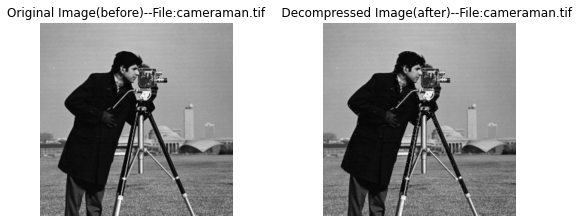

----File:cameraman.tif----RMSE: 1.451274390726211
----File:cameraman.tif----PSNR: 44.895812973814856
   
--------house.tif_encoder_bitstream is done.--------


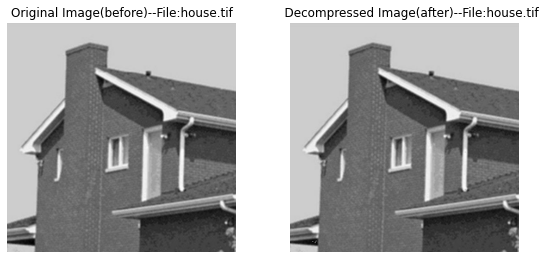

----File:house.tif----RMSE: 1.0559689119560187
----File:house.tif----PSNR: 47.65778095617578
   
--------jetplane.tif_encoder_bitstream is done.--------


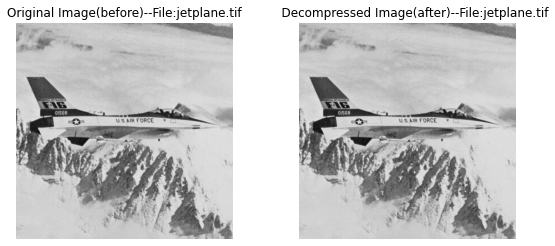

----File:jetplane.tif----RMSE: 1.347635020213217
----File:jetplane.tif----PSNR: 45.539357844365384
   
--------lake.tif_encoder_bitstream is done.--------


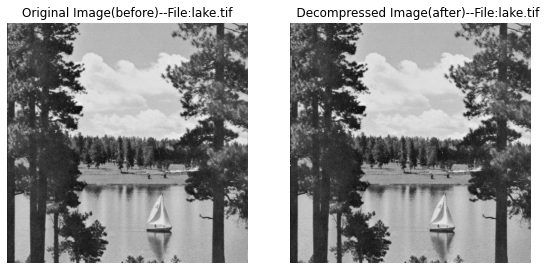

----File:lake.tif----RMSE: 1.5240946599442906
----File:lake.tif----PSNR: 44.470564780224564
   
--------lena_color_512.tif_encoder_bitstream is done.--------


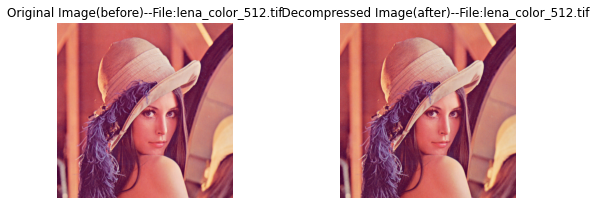

----File:lena_color_512.tif----RMSE: 3.674019867515388
----File:lena_color_512.tif----PSNR: 36.82797359961008
   
--------lena_gray_512.tif_encoder_bitstream is done.--------


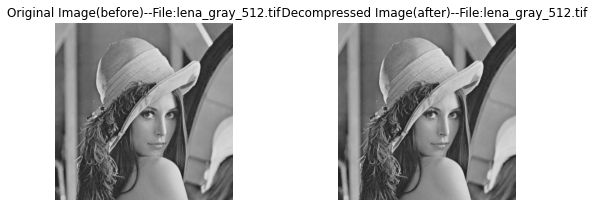

----File:lena_gray_512.tif----RMSE: 1.3897853416619552
----File:lena_gray_512.tif----PSNR: 45.27184907310559
   
--------livingroom.tif_encoder_bitstream is done.--------


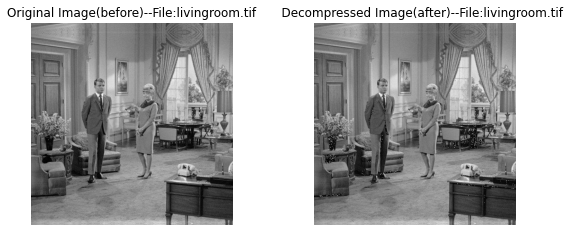

----File:livingroom.tif----RMSE: 1.7587595105269909
----File:livingroom.tif----PSNR: 43.2266744305753
   
--------mandril_color.tif_encoder_bitstream is done.--------


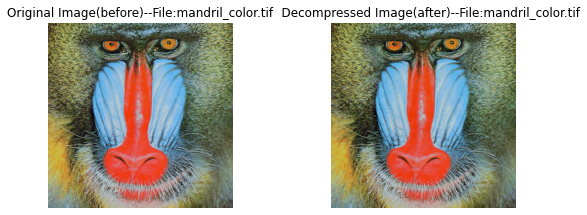

----File:mandril_color.tif----RMSE: 5.053604285056177
----File:mandril_color.tif----PSNR: 34.05877896600328
   
--------mandril_gray.tif_encoder_bitstream is done.--------


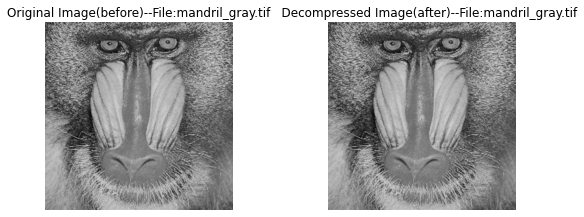

----File:mandril_gray.tif----RMSE: 1.9429912889474779
----File:mandril_gray.tif----PSNR: 42.36138653822255
   
--------peppers_color.tif_encoder_bitstream is done.--------


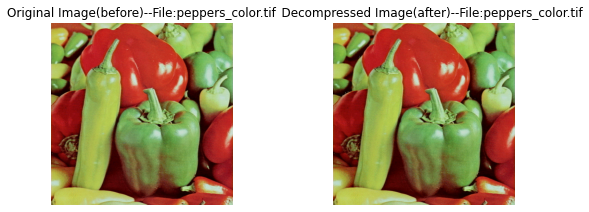

----File:peppers_color.tif----RMSE: 3.969858570414291
----File:peppers_color.tif----PSNR: 36.155302910105696
   
--------peppers_gray.tif_encoder_bitstream is done.--------


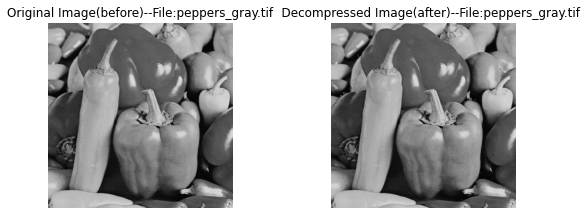

----File:peppers_gray.tif----RMSE: 1.3546720686476925
----File:peppers_gray.tif----PSNR: 45.494120081051065
   
--------pirate.tif_encoder_bitstream is done.--------


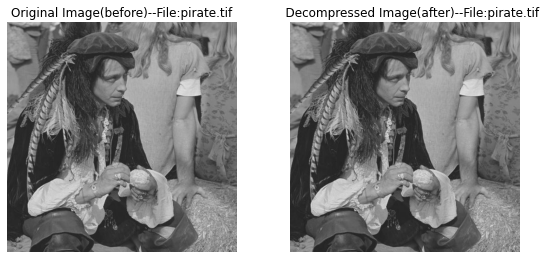

----File:pirate.tif----RMSE: 1.6023114197890271
----File:pirate.tif----PSNR: 44.03586504972074
   
--------walkbridge.tif_encoder_bitstream is done.--------


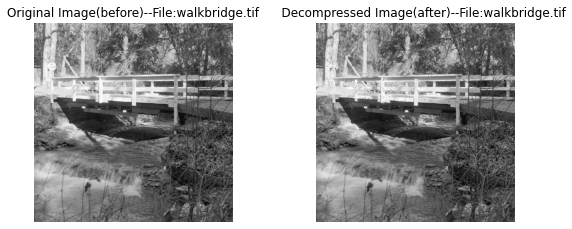

----File:walkbridge.tif----RMSE: 1.8515944337304227
----File:walkbridge.tif----PSNR: 42.7798862779758
   
--------woman_blonde.tif_encoder_bitstream is done.--------


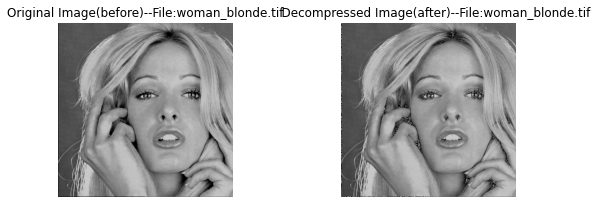

----File:woman_blonde.tif----RMSE: 1.52131888942788
----File:woman_blonde.tif----PSNR: 44.486398454470645
   
--------woman_darkhair.tif_encoder_bitstream is done.--------


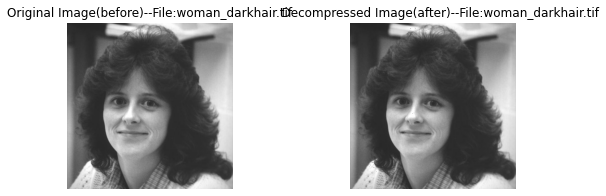

----File:woman_darkhair.tif----RMSE: 1.0829157880481317
----File:woman_darkhair.tif----PSNR: 47.438909900143045
   


In [ ]:
import matplotlib

np.seterr(divide='ignore',invalid='ignore')

for name in ['cameraman.tif','house.tif','jetplane.tif', 'lake.tif', 'lena_color_512.tif', 'lena_gray_512.tif','livingroom.tif', 'mandril_color.tif', 'mandril_gray.tif','peppers_color.tif','peppers_gray.tif', 'pirate.tif', 'walkbridge.tif', 'woman_blonde.tif', 'woman_darkhair.tif']:
    matplotlib.rcParams['font.size'] = 10    
    # Read image
    im = np.array(Image.open('/{}'.format(name)).convert('RGB'), dtype = 'uint8')

    #Encoder
    encoder('/{}'.format(name),'/content/{}_encoder_bitstream'.format(name))
    print('--------{}_encoder_bitstream is done.--------'.format(name))
    
    # Decoder
    im2 = decoder('/content/'+str(name)+'_encoder_bitstream')
    
    # Specify the data type so that float value will be converted to int
    im2 = np.array(Image.open('/content/'+str(name)+'_decoder_bitstream.png'), dtype = 'uint8')
      
    fig, (ax1, ax2) = plt.subplots(nrows=1, 
                                        ncols=2, 
                                        figsize=(8, 5),
                                        sharex=True, 
                                        sharey=True)
    for aa in (ax1, ax2):
        aa.set_axis_off()
      
    # displaying images
    ax1.imshow(im)
    ax1.set_title('Original Image(before)'+'--File:'+str(name))
    ax2.imshow(im2)
    ax2.set_title('    Decompressed Image(after)'+'--File:'+str(name))
      
    plt.tight_layout()
    plt.show()


    # Calculate RMSE and PSNR
    rmse_val = rmse(im, im2)
    psnr_val = psnr(im, im2)

    print('----File:'+str(name)+'----RMSE:', rmse_val)
    print('----File:'+str(name)+'----PSNR:', psnr_val)
    print("   ")

## **5.Embed the Huffman table into the Header of the encoded bitstream (file-stream) to achieve a better compression ratio.**

In [ ]:
from collections import defaultdict
from typing import List, Tuple, Dict, BinaryIO


# Zig-zag scan order (# https://www.w3.org/Graphics/JPEG/itu-t81.pdf, Figure A.6)
zigzag = [(0, 0), (0, 1), (1, 0), (2, 0), (1, 1), (0, 2), (0, 3), (1, 2),
          (2, 1), (3, 0), (4, 0), (3, 1), (2, 2), (1, 3), (0, 4), (0, 5),
          (1, 4), (2, 3), (3, 2), (4, 1), (5, 0), (6, 0), (5, 1), (4, 2),
          (3, 3), (2, 4), (1, 5), (0, 6), (0, 7), (1, 6), (2, 5), (3, 4),
          (4, 3), (5, 2), (6, 1), (7, 0), (7, 1), (6, 2), (5, 3), (4, 4),
          (3, 5), (2, 6), (1, 7), (2, 7), (3, 6), (4, 5), (5, 4), (6, 3),
          (7, 2), (7, 3), (6, 4), (5, 5), (4, 6), (3, 7), (4, 7), (5, 6),
          (6, 5), (7, 4), (7, 5), (6, 6), (5, 7), (6, 7), (7, 6), (7, 7)]


class HuffmanTable:
    table_class: int
    dest_id: int
    counts: List[int]
    huff_data: Dict[Tuple[int, int], int]


class QuantizationTable:
    precision: int
    dest_id: int
    table: List[List[int]]


class FrameComponent:
    identifier: int
    sampling_factor: int
    h_sampling_factor: int
    v_sampling_factor: int
    quant_table_dest: int


class StartOfFrame:
    precision: int
    num_lines: int
    samples_per_line: int
    components: List[FrameComponent]


class ScanComponent:
    selector: int
    dc_table: int
    ac_table: int


class StartOfScan:
    components: List[ScanComponent]
    spectral_selection_range: Tuple[int, int]
    successive_approximation: int


def define_huffman_table(file: BinaryIO) -> List[HuffmanTable]:
    # https://www.w3.org/Graphics/JPEG/itu-t81.pdf, B.2.4.2
    
    # Lh: Huffman table definition length – Specifies the length of all Huffman table parameters
    size = int.from_bytes(file.read(2), byteorder="big")

    huff_tables = []

    bytes_left = size - 2
    while bytes_left > 0:
        huff_table = HuffmanTable()
        huff_table.huff_data = {}

        table = int.from_bytes(file.read(1), byteorder="big")
        # Tc: Table class – 0 = DC table or lossless table, 1 = AC table
        huff_table.table_class = table >> 4

        # Th: Huffman table destination identifier – Specifies one of four possible destinations at the decoder into
        # which the Huffman table shall be installed
        huff_table.dest_id = table & 0b1111

        # Li: Number of Huffman codes of length i – Specifies the number of Huffman codes for each of the 16 possible
        # lengths allowed by this Specification. Li’s are the elements of the list BITS.
        huff_table.counts = [int.from_bytes(file.read(1), byteorder="big") for _ in range(16)]

        length_codes_map = defaultdict(list)
        # Incrementing code used to build Huffman map
        code = 0
        for i in range(16):
            # Go through number of codes in each length
            for j in range(huff_table.counts[i]):
                huff_byte = int.from_bytes(file.read(1), byteorder="big")
                huff_table.huff_data[(code, i+1)] = huff_byte
                length_codes_map[i+1].append(huff_byte)

                # increment code
                code += 1

            # Shift bits to left (increase length by 1)
            code <<= 1

        bytes_left -= 17 + sum(huff_table.counts)

        print(f"Huffman table length: {size}")
        print(f"Destination ID: {huff_table.dest_id}")
        print(f"Class = {huff_table.table_class} (" +
              ("DC / Lossless table" if huff_table.table_class == 0 else "AC table") + ")")

        for i in range(16):
            print(f"    Codes of length {i+1} bits ({huff_table.counts[i]} total): ", end="")
            for huff_byte in length_codes_map[i+1]:
                print(f"{huff_byte:02X} ", end="")
            print()

        print(f"Total number of codes: {sum(huff_table.counts)}")
        print()

        huff_tables.append(huff_table)

    return huff_tables


def define_quantization_table(file: BinaryIO) -> List[QuantizationTable]:
    # https://www.w3.org/Graphics/JPEG/itu-t81.pdf, B.2.4.1

    # Lq: Quantization table definition length – Specifies the length of all quantization table parameters
    size = int.from_bytes(file.read(2), byteorder="big")

    quant_tables = []

    bytes_left = size - 2
    while bytes_left > 0:
        quant_table = QuantizationTable()
        quant_table.table = {}

        # Create empty 8x8 table
        quant_table.table = [[0 for _ in range(8)] for _ in range(8)]

        temp = int.from_bytes(file.read(1), byteorder="big")
        # Pq: Quantization table element precision – Specifies the precision of the Qk values. Value 0 indicates 8-bit
        # Qk values; value 1 indicates 16-bit Qk values. Pq shall be zero for 8 bit sample precision P.
        quant_table.precision = temp >> 4
        element_bytes = 1 if quant_table.precision == 0 else 2

        # Tq: Quantization table destination identifier – Specifies one of four possible destinations at the decoder
        # into
        # which the quantization table shall be installed
        quant_table.dest_id = temp & 0b1111

        bytes_left -= 65 + (64 * quant_table.precision)

        for i in range(64):
            # Qk: Quantization table element – Specifies the kth element out of 64 elements, where k is the index in
            # the zigzag ordering of the DCT coefficients.
            # The quantization elements shall be specified in zig-zag scan order.
            element = int.from_bytes(file.read(element_bytes), byteorder="big")

            row, col = zigzag[i]
            quant_table.table[row][col] = element

        print(f"Quantization table length: {size}")
        print("Precision: " + ("8 bits" if quant_table.precision == 0 else "16 bits"))
        print("Destination ID: " + str(quant_table.dest_id) +
              (" (Luminance)" if quant_table.dest_id == 0 else " (Chrominance)"))
        for i in range(len(quant_table.table)):
            print(f"    DQT, Row #{i}: " + "".join(str(element).rjust(4) for element in quant_table.table[i]))
        print()

        quant_tables.append(quant_table)
    return quant_tables


def read_start_of_frame(file: BinaryIO) -> StartOfFrame:
    # https://www.w3.org/Graphics/JPEG/itu-t81.pdf, B.2.2
    sof = StartOfFrame()
    sof.components = []

    # Lf: Frame header length – Specifies the length of the frame header
    size = int.from_bytes(file.read(2), byteorder="big")

    # P: Sample precision – Specifies the precision in bits for the samples of the components in the frame.
    sof.precision = int.from_bytes(file.read(1), byteorder="big")

    # Y: Number of lines – Specifies the maximum number of lines in the source image. This shall be equal to the
    # number of lines in the component with the maximum number of vertical samples (see A.1.1). Value 0 indicates
    # that the number of lines shall be defined by the DNL marker and parameters at the end of the first scan (see
    # B.2.5).
    sof.num_lines = int.from_bytes(file.read(2), byteorder="big")

    # X: Number of samples per line – Specifies the maximum number of samples per line in the source image. This
    # shall be equal to the number of samples per line in the component with the maximum number of horizontal
    # samples (see A.1.1).
    sof.samples_per_line = int.from_bytes(file.read(2), byteorder="big")

    # Nf: Number of image components in frame – Specifies the number of source image components in the frame.
    # The value of Nf shall be equal to the number of sets of frame component specification parameters (Ci, Hi, Vi,
    # and Tqi) present in the frame header.
    sof.num_frame_components = int.from_bytes(file.read(1), byteorder="big")

    for i in range(sof.num_frame_components):
        component = FrameComponent()

        # Ci: Component identifier – Assigns a unique label to the ith component in the sequence of frame component
        # specification parameters. These values shall be used in the scan headers to identify the components in the
        # scan. The value of Ci shall be different from the values of C1 through Ci − 1.
        component.identifier = int.from_bytes(file.read(1), byteorder="big")

        component.sampling_factor = int.from_bytes(file.read(1), byteorder="big")

        # Hi: Horizontal sampling factor – Specifies the relationship between the component horizontal dimension
        # and maximum image dimension X (see A.1.1); also specifies the number of horizontal data units of component
        # Ci in each MCU, when more than one component is encoded in a scan.
        component.h_sampling_factor = component.sampling_factor >> 4

        # Vi: Vertical sampling factor – Specifies the relationship between the component vertical dimension and
        # maximum image dimension Y (see A.1.1); also specifies the number of vertical data units of component Ci in
        # each MCU, when more than one component is encoded in a scan.
        component.v_sampling_factor = component.sampling_factor & 0b1111

        # Tqi: Quantization table destination selector – Specifies one of four possible quantization table destinations
        # from which the quantization table to use for dequantization of DCT coefficients of component Ci is retrieved.
        # If the decoding process uses the dequantization procedure, this table shall have been installed in this
        # destination by the time the decoder is ready to decode the scan(s) containing component Ci. The destination
        # shall not be respecified, or its contents changed, until all scans containing Ci have been completed.
        component.quant_table_dest = int.from_bytes(file.read(1), byteorder="big")

        sof.components.append(component)

    print(f"Frame header length: {size}")
    print(f"Precision: {sof.precision}")
    print(f"Number of lines: {sof.num_lines}")
    print(f"Samples per line: {sof.samples_per_line}")
    print(f"Image size: {sof.samples_per_line} x {sof.num_lines}")

    print(f"Number of image components: {sof.num_frame_components}")
    for i, component in enumerate(sof.components):
        print(f"    Component {i+1}: ID=0x{component.identifier:X}, "
              f"Sampling factor=0x{component.sampling_factor:X}, "
              f"Vertical sampling factor=0x{component.v_sampling_factor:X}, "
              f"Horizontal sampling factor=0x{component.h_sampling_factor:X}, "
              f"Quantization table destination=0x{component.quant_table_dest}")
    print()

    return sof


def read_start_of_scan(file: BinaryIO) -> StartOfScan:
    # https://www.w3.org/Graphics/JPEG/itu-t81.pdf, B.2.3
    sos = StartOfScan()
    sos.components = []

    # Ls: Scan header length – Specifies the length of the scan header.
    size = int.from_bytes(file.read(2), byteorder="big")

    # Ns: Number of image components in scan – Specifies the number of source image components in the scan. The
    # value of Ns shall be equal to the number of sets of scan component specification parameters (Csj, Tdj, and Taj)
    # present in the scan header.
    sos.num_scan_components = int.from_bytes(file.read(1), byteorder="big")

    for i in range(sos.num_scan_components):
        component = ScanComponent()

        # Csj: Scan component selector – Selects which of the Nf image components specified in the frame parameters
        # shall be the jth component in the scan. Each Csj shall match one of the Ci values specified in the frame
        # header, and the ordering in the scan header shall follow the ordering in the frame header.
        component.selector = int.from_bytes(file.read(1), byteorder="big")

        temp = int.from_bytes(file.read(1), byteorder="big")

        # Tdj: DC entropy coding table destination selector – Specifies one of four possible DC entropy coding table
        # destinations from which the entropy table needed for decoding of the DC coefficients of component Csj is
        # retrieved. The DC entropy table shall have been installed in this destination (see B.2.4.2 and B.2.4.3) by the
        # time the decoder is ready to decode the current scan. This parameter specifies the entropy coding table
        # destination for the lossless processes.
        component.dc_table = temp >> 4

        # Taj: AC entropy coding table destination selector – Specifies one of four possible AC entropy coding table
        # destinations from which the entropy table needed for decoding of the AC coefficients of component Csj is
        # retrieved. The AC entropy table selected shall have been installed in this destination (see B.2.4.2 and
        # B.2.4.3) by the time the decoder is ready to decode the current scan. This parameter is zero for the
        # lossless processes.
        component.ac_table = temp & 0b1111

        sos.components.append(component)

    # Ss: Start of spectral or predictor selection – In the DCT modes of operation, this parameter specifies the first
    # DCT coefficient in each block in zig-zag order which shall be coded in the scan. This parameter shall be set to
    # zero for the sequential DCT processes. In the lossless mode of operations this parameter is used to select the
    # predictor
    spectral_selection_start = int.from_bytes(file.read(1), byteorder="big")

    # Se: End of spectral selection – Specifies the last DCT coefficient in each block in zig-zag order which shall be
    # coded in the scan. This parameter shall be set to 63 for the sequential DCT processes. In the lossless mode of
    # operations this parameter has no meaning. It shall be set to zero.
    spectral_selection_end = int.from_bytes(file.read(1), byteorder="big")

    sos.spectral_selection_range = (spectral_selection_start, spectral_selection_end)

    sos.successive_approximation = int.from_bytes(file.read(1), byteorder="big")

    print(f"Scan header length: {size}")
    print(f"Number of image components: {sos.num_scan_components}")
    for i, component in enumerate(sos.components):
        print(f"    Component {i+1}: selector=0x{component.selector:02X}, "
              f"table={component.dc_table}(DC),{component.ac_table}(AC)")
    print(f"Spectral selection: {sos.spectral_selection_range[0]} .. {sos.spectral_selection_range[1]}")
    print(f"Successive approximation: 0x{sos.successive_approximation:02X}")
    print()

    return sos

In [ ]:
from typing import Dict, Tuple, List
from time import time
import math
import tkinter

IMAGE_TO_OPEN = "/lake.png"

start_time = time()


class PhotoDisplay:
    def __init__(self, tk, height, width, rgb_array: List[List[Tuple[int, int, int]]]):
        self.width = width
        self.height = height

        self.i = tkinter.PhotoImage(width=width, height=height)
        pixels = " ".join(("{" + " ".join(("#%02x%02x%02x" % rgb_array[color_row][color_col]
                                           for color_col in range(width))) + "}" for color_row in range(height)))
        self.i.put(pixels, (0, 0, self.width, self.height))

        self.canvas = tkinter.Canvas(tk, width=self.width, height=self.height)
        self.canvas.pack()
        self.canvas.create_image(0, 0, image=self.i, anchor=tkinter.NW)

        self.canvas.bind("<ButtonPress-1>", self.scroll_start)
        self.canvas.bind("<B1-Motion>", self.scroll_move)

    def scroll_start(self, event):
        self.canvas.scan_mark(event.x, event.y)

    def scroll_move(self, event):
        self.canvas.scan_dragto(event.x, event.y, gain=1)


def bit_from_bytearray(arr: bytearray, bit_idx: int, order: str) -> int:
    if order == "little":
        return (arr[bit_idx // 8] & (0b1 << (bit_idx % 8))) >> (bit_idx % 8)
    else:
        return (arr[bit_idx // 8] & (0b1 << (7 - (bit_idx % 8)))) >> (7 - (bit_idx % 8))


def bits_from_bytearray(arr: bytearray, start_idx: int, num_bits: int, order: str) -> int:
    out = 0
    for bit_idx in range(start_idx, start_idx + num_bits):
        out = (out << 1) | bit_from_bytearray(arr, bit_idx, order)
    return out


def get_signed_value(bits: int, num_bits: int) -> int:

    # if output should be positive, output our bits
    # if output should be negative, output the maximum negative value plus our bits
    if bits < 2**(num_bits - 1):  # Check if bits is less than the middle value
        min_val = (-1 << num_bits) + 1
        return min_val + bits

    return bits


def get_next_huffman_value(data: bytearray, data_pos: int, huff_table: Dict[Tuple[int, int], int],
                           debug_print=False) -> Tuple[int, int]:
    # DECODE
    encoded_bits = bit_from_bytearray(data, data_pos, "big")
    start_bit = data_pos
    curr_pos = data_pos + 1

    while (encoded_bits, curr_pos - start_bit) not in huff_table:
        encoded_bits = (encoded_bits << 1) | bit_from_bytearray(scan_data, curr_pos, "big")
        curr_pos += 1

    num_bits = curr_pos - start_bit

    if debug_print:
        print(f"encoded: {encoded_bits:0{num_bits}b}, length: {num_bits}")
    return huff_table[(encoded_bits, num_bits)], num_bits


def ycbcr_to_rgb(lum, chrom_blue, chrom_red) -> Tuple[int, int, int]:
    # https://www.impulseadventure.com/photo/jpeg-color-space.html
    red = chrom_red * (2 - 2 * 0.299) + lum
    blue = chrom_blue * (2 - 2 * 0.114) + lum
    green = (lum - 0.114 * blue - 0.299 * red) / 0.587
    return min(255, max(0, round(red + 128))), min(255, max(0, round(green + 128))), min(255, max(0, round(blue + 128)))


# Define JPEG segment names according to offset from 0xFFC0
# Table B.1
seg_names = ["SOF0 - Baseline DCT; Huffman", "SOF1 - Extended sequential DCT; Huffman",
             "SOF2 - Progressive DCT; Huffman", "SOF3 - Lossless (sequential); Huffman",
             "DHT - Define Huffman table(s)", "SOF5 - Differential sequential DCT; Huffman",
             "SOF6 - Differential progressive DCT; Huffman", "SOF7 - Differential lossless (sequential); Huffman",
             "JPG - Reserved for JPEG extensions", "SOF9 - Extended sequential DCT; Arithmetic",
             "SOF10 - Progressive DCT; Arithmetic", "SOF11 - Lossless (sequential); Arithmetic",
             "DAC - Define arithmetic coding conditioning(s)", "SOF13 - Differential sequential DCT; Arithmetic",
             "SOF14 - Differential progressive DCT; Arithmetic",
             "SOF15 - Differential lossless (sequential); Arithmetic",
             "RST0 - Restart with modulo 8 count 0", "RST0 - Restart with modulo 8 count 1",
             "RST0 - Restart with modulo 8 count 2", "RST0 - Restart with modulo 8 count 3",
             "RST0 - Restart with modulo 8 count 4", "RST0 - Restart with modulo 8 count 5",
             "RST0 - Restart with modulo 8 count 6", "RST0 - Restart with modulo 8 count 7",
             "SOI - Start of image", "EOI - End of image", "SOS - Start of scan", "DQT - Define quantization table(s)",
             "DNL - Define number of lines", "DRI - Define restart interval", "DHP - Define hierarchical progression",
             "EXP - Expand reference components", "JFIF header"]
seg_names.extend(["[Reserved: Application segments]"] * 16)
seg_names.extend(["[Reserved: JPEG extension]"] * 14)
seg_names.extend(["Comment", "[Invalid]"])

# Create necessary variables to store header information
huff_tables = {}
quant_tables = {}
#sof: jpeg_headers.StartOfFrame

# Precalculate IDCT constants (A.3.3)
idct_lookup = []
for y in range(8):
    idct_row = []
    for x in range(8):
        uv_matrix = []
        for u in range(8):
            uv_row = []
            for v in range(8):
                cu = (1 / math.sqrt(2)) if u == 0 else 1
                cv = (1 / math.sqrt(2)) if v == 0 else 1
                uv_row.append(cu * cv *
                              math.cos(((2 * x + 1) * u * math.pi) / 16) * math.cos(((2 * y + 1) * v * math.pi) / 16))
            uv_matrix.append(uv_row)
        idct_row.append(uv_matrix)
    idct_lookup.append(idct_row)

with open(IMAGE_TO_OPEN, "rb") as f:
    block_id_bytes = f.read(2)
    while block_id_bytes:
        block_id = int.from_bytes(block_id_bytes, byteorder="big")
        pos = f.tell() - 2

        if block_id < 0xFFC0:
            print("Segment ID expected, not found.")
            break  # JPEG_SEG_ERR

        print(f"*** Marker: {seg_names[block_id - 0xFFC0]}, (0x{block_id:04X}) ***")
        print(f"OFFSET: {pos} (0x{pos:X})\n")

        if block_id == 0xFFD9:    # -------------------------------------- End of Image
            print(f"Decoding process took {time() - start_time} seconds")

            # Show decoded RGB array
            t = tkinter.Tk()
            t.resizable(False, False)
            t.title("decoded image")
            display = PhotoDisplay(t, sof.num_lines, sof.samples_per_line, image_rgb)
            t.mainloop()

            break
        elif block_id == 0xFFDA:  # -------------------------------------- Start of Scan
            sos = read_start_of_scan(f)
            assert sof is not None

            # Get maximum sampling factors and number of MCUs
            max_h_sampling_factor = 0
            max_v_sampling_factor = 0
            for component in sof.components:
                max_h_sampling_factor = max(max_h_sampling_factor, component.h_sampling_factor)
                max_v_sampling_factor = max(max_v_sampling_factor, component.v_sampling_factor)

            mcu_size_x = 8 * max_h_sampling_factor
            mcu_size_y = 8 * max_v_sampling_factor

            num_mcu_x = math.ceil(sof.samples_per_line / mcu_size_x)
            num_mcu_y = math.ceil(sof.num_lines / mcu_size_y)

            print(f"MCU Size: {mcu_size_x} x {mcu_size_y}")
            print(f"{num_mcu_x} MCU cols, {num_mcu_y} MCU rows\n")

            # Read data that's left
            start_pos = f.tell()
            f.seek(0, 2)
            end_pos = f.tell()

            f.seek(start_pos)
            scan_data = bytearray(f.read(end_pos - start_pos))

            # Scan for next marker and remove all stuff bytes in scan data
            marker_pos = None
            marker_pos_diff = 0

            for i in range(len(scan_data) - 2, 0, -1):  # scan backwards
                marker_code = scan_data[i:i + 2]

                # Remove stuff byte
                if marker_code == b'\xFF\x00':
                    scan_data.pop(i + 1)
                    marker_pos_diff += 1

                # Marker found if 0xFF exists without a stuff byte after
                elif marker_code > b'\xFF\x00':
                    if b'\xFF\xD0' <= marker_code <= b'\xFF\xD7':
                        # TODO: RSTm (restart marker) found
                        # remove the 0xFF and continue
                        print('restart marker found, skipping...')
                        scan_data.pop(i)
                        marker_pos_diff += 1
                    else:
                        marker_pos = i
                        marker_pos_diff = 0

            assert marker_pos is not None

            # Set scan data from start to next marker
            scan_data = scan_data[:marker_pos - marker_pos_diff]
            f.seek(start_pos + marker_pos)

            print("Scan data: (after bitstuff removed)")
            print("  " + "".join(f"{b:02x} " +
                                 ("\n  " if (idx + 1) % 36 == 0 else "") for idx, b in enumerate(scan_data[:720])))
            if len(scan_data) > 720:
                print("WARNING: Dump truncated.")
            print()
            # block_id_bytes = f.read(2)
            # continue

            # Initialize array storing final RGB values
            image_rgb = [[(0, 0, 0) for _ in range(sof.samples_per_line)] for _ in range(sof.num_lines)]

            # F.2.1.2
            # Figure E.9
            # Figure E.10
            curr_bit = 0

            # Initialize DC predictions for each component to zero
            predictions = [0 for _ in range(len(sos.components))]

            # Loop through all MCUs in image
            for mcu_row in range(num_mcu_y):
                print(f"Processing MCU row {mcu_row}")
                for mcu_col in range(num_mcu_x):
                    debug = False
                    if debug:
                        print(f"\nMCU {mcu_row}, {mcu_col}")

                    # List of MCUs (could contain luminance, chrominance blue, chrominance red or just one)
                    mcu_arr = []

                    # Decode each MCU
                    for component_idx, component in enumerate(sos.components):
                        frame_component = None
                        for c in sof.components:
                            if c.identifier == component.selector:
                                frame_component = c
                                break
                        assert frame_component is not None

                        quant_table = quant_tables[frame_component.quant_table_dest]
                        dc_huff_table = huff_tables[component.dc_table, 0]
                        ac_huff_table = huff_tables[component.ac_table, 1]

                        # Initialize 2D array for MCU
                        mcu = [[0 for _ in range(8 * frame_component.h_sampling_factor)]
                               for _ in range(8 * frame_component.v_sampling_factor)]

                        # Go through all data units in order specified by A.2.3
                        for data_unit_row in range(frame_component.v_sampling_factor):
                            for data_unit_col in range(frame_component.h_sampling_factor):
                                if debug:
                                    if frame_component.quant_table_dest == 0:
                                        print("Lum")
                                    else:
                                        print("Chr")

                                # Decode DC coefficient
                                dc_code, length = get_next_huffman_value(scan_data, curr_bit, dc_huff_table, debug)
                                curr_bit += length

                                # RECEIVE
                                # A.3.5, F.2.1.3.1
                                additional_bits = bits_from_bytearray(scan_data, curr_bit, dc_code, "big")
                                curr_bit += dc_code

                                diff = get_signed_value(additional_bits, dc_code)
                                abs_dc_value = predictions[component_idx] + diff

                                predictions[component_idx] = abs_dc_value

                                if debug:
                                    start_byte = (curr_bit - dc_code - length) // 8
                                    print(f"val: {diff}, coeff: 00=DC")
                                    print(f"val_bits: {additional_bits:0{dc_code}b}")
                                    print(f"data: 0x "
                                          f"{' '.join(hex(b)[2:] for b in scan_data[start_byte:start_byte + 4])}\n")

                                # Start decoding DCT matrix
                                dct_coeffs = [0 for _ in range(64)]
                                dct_coeffs[0] = abs_dc_value

                                # Decode AC coefficients, F.2.2.2
                                # Figure F.13
                                k = 0
                                while k != 63:
                                    k += 1

                                    # rs (8 bits)-> rrrrssss
                                    rs, length = get_next_huffman_value(scan_data, curr_bit, ac_huff_table, debug)
                                    curr_bit += length

                                    rrrr = rs >> 4  # Skip
                                    ssss = rs & 0b1111  # Coded length

                                    if ssss == 0:
                                        if rrrr == 15:
                                            k += 15
                                            continue
                                        else:
                                            if debug:
                                                print("EOB")
                                            break

                                    k += rrrr

                                    # Decode_ZZ
                                    # ZZ(k) = RECEIVE(ssss)
                                    additional_bits = bits_from_bytearray(scan_data, curr_bit, ssss, "big")
                                    curr_bit += ssss

                                    # ZZ(k) = EXTEND(ZZ(k), ssss)
                                    v = get_signed_value(additional_bits, ssss)

                                    if debug:
                                        start_byte = (curr_bit - ssss - length) // 8
                                        print(f"val: {v}, coeff: {k-rrrr:02d}..{k:02d}, skip: {rrrr}")
                                        print(f"val_bits: {additional_bits:0{ssss}b}")
                                        print(f"data: 0x "
                                              f"{' '.join(hex(b)[2:] for b in scan_data[start_byte:start_byte+4])}\n")

                                    dct_coeffs[k] = v

                                # Zig-zag reorder AC and DC coefficient list into DCT matrix
                                # Multiply each value by its corresponding value in the quantization table to dequantize
                                dct_matrix = [[0 for _ in range(8)] for _ in range(8)]
                                for i, coeff in enumerate(dct_coeffs):
                                    row, col = zigzag[i]
                                    dct_matrix[row][col] = coeff * quant_table[row][col]

                                # Perform IDCT (A.3.3)
                                for y in range(8):
                                    for x in range(8):
                                        val = 0
                                        for u in range(8):
                                            for v in range(8):
                                                val += idct_lookup[y][x][u][v] * dct_matrix[v][u]
                                        val /= 4

                                        # Assign value in MCU
                                        mcu[(data_unit_row * 8) + y][(data_unit_col * 8) + x] = val

                        # Expand MCU to maximum MCU size by duplicating values vertically or horizontally
                        horiz_multiplier = max_h_sampling_factor // frame_component.h_sampling_factor
                        vert_multiplier = max_v_sampling_factor // frame_component.v_sampling_factor

                        if vert_multiplier > 1 or horiz_multiplier > 1:
                            mcu = [[val for val in row for _ in range(horiz_multiplier)]
                                   for row in mcu for _ in range(vert_multiplier)]

                        # Append MCU to MCU array
                        mcu_arr.append(mcu)

                    # TODO: Handle images with one component
                    # Convert all Y, Cb, and Cr component values to RGB and store them in array
                    for i in range(mcu_size_y):
                        # Break if MCU goes past y bounds of image
                        if (mcu_row * mcu_size_y) + i >= sof.num_lines:
                            break

                        for j in range(mcu_size_x):
                            # Break if MCU goes past x bounds of image
                            if (mcu_col * mcu_size_x) + j >= sof.samples_per_line:
                                break

                            image_rgb[(mcu_row * mcu_size_y) + i][(mcu_col * mcu_size_x) + j] = \
                                ycbcr_to_rgb(mcu_arr[0][i][j], mcu_arr[1][i][j], mcu_arr[2][i][j])
                            

        elif block_id == 0xFFD8:  # -------------------------------------- Start of Image
            pass
        elif block_id == 0xFFC4:  # -------------------------------------- Define Huffman Table
            for table in define_huffman_table(f):
                huff_tables[table.dest_id, table.table_class] = table.huff_data
        elif block_id == 0xFFDB:  # -------------------------------------- Define Quantization Table
            for table in define_quantization_table(f):
                quant_tables[table.dest_id] = table.table
        elif block_id == 0xFFC0 or block_id == 0xFFC1:  # ---------------- Start of Frame
            sof = read_start_of_frame(f)
        else:  # All other segments have length specified at the start, skip for now
            size = int.from_bytes(f.read(2), byteorder="big")
            f.seek(size - 2, 1)

        block_id_bytes = f.read(2)

Segment ID expected, not found.


In [ ]:
from collections import Counter
from heapq import heappush, heappop

# Data structure to represent the Huffman table
class HuffmanTable:
    def __init__(self, table):
        self.table = table

# Function to generate the Huffman table
def generate_huffman_table(symbols, frequencies):
    # Build the Huffman tree
    heap = []
    for symbol, freq in frequencies.items():
        heappush(heap, (freq, symbol))
    while len(heap) > 1:
        freq1, symbol1 = heappop(heap)
        freq2, symbol2 = heappop(heap)
        heappush(heap, (freq1 + freq2, (symbol1, symbol2)))
    # Generate the Huffman codes
    codes = {}
    def generate_codes(tree, code):
        if isinstance(tree, tuple):
            generate_codes(tree[0], code + '0')
            generate_codes(tree[1], code + '1')
        else:
            codes[tree] = code
    generate_codes(heap[0][1], '')
    # Create the Huffman table
    table = []
    for symbol, code in codes.items():
        table.append((symbol, code))
    return HuffmanTable(table)

# Function to write the Huffman table to the header of the encoded bitstream
def write_huffman_table(bitstream, huffman_table):
    # Write the number of symbols in the table
    bitstream.write(len(huffman_table.table))
    # Write the symbol and code for each symbol in the table
    for symbol, code in huffman_table.table:
        bitstream.write(symbol)
        bitstream.write(code)

# Function to read the Huffman table from the header of the encoded bitstream
def read_huffman_table(bitstream):
    # Read the number of symbols in the table
    num_symbols = bitstream.read()
    # Read the symbol and code for each symbol in the table
    table = []
    for i in range(num_symbols):
        symbol = bitstream.read()
        code = bitstream.read()
        table.append((symbol, code))
    return HuffmanTable(table)

--------cameraman.tif_encoder_bitstream is done.--------


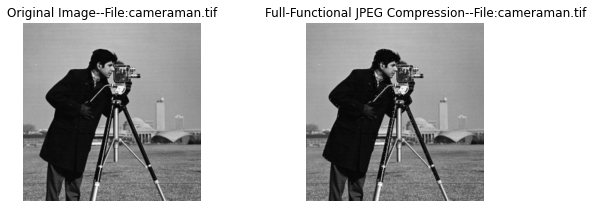

   
--------house.tif_encoder_bitstream is done.--------


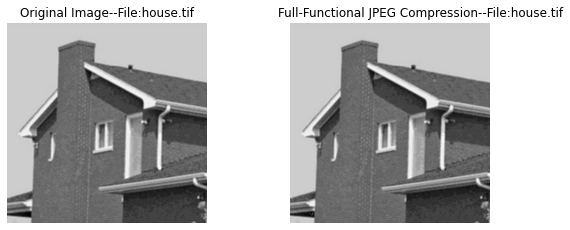

   
--------jetplane.tif_encoder_bitstream is done.--------


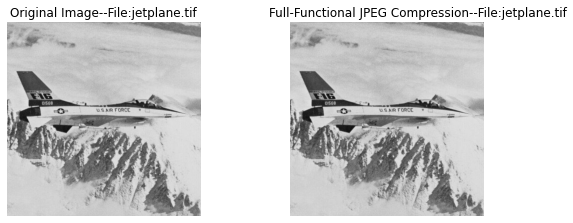

   
--------lake.tif_encoder_bitstream is done.--------


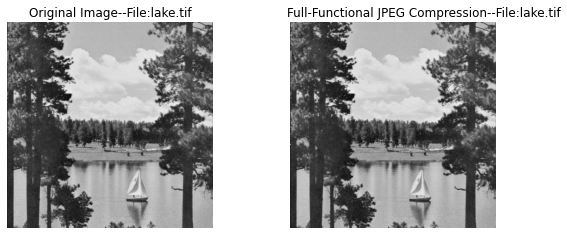

   
--------lena_color_512.tif_encoder_bitstream is done.--------


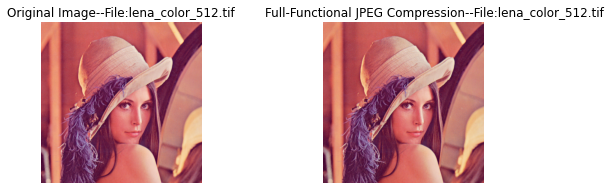

   
--------lena_gray_512.tif_encoder_bitstream is done.--------


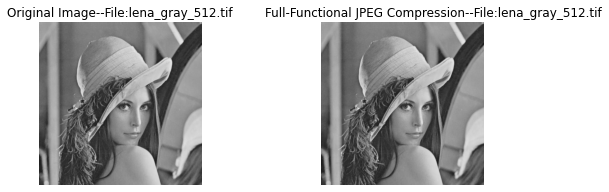

   
--------livingroom.tif_encoder_bitstream is done.--------


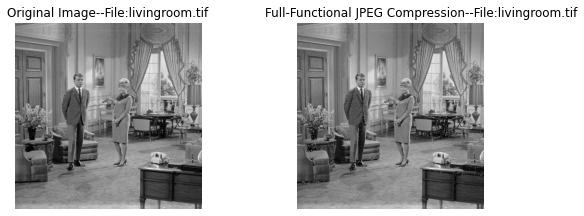

   
--------mandril_color.tif_encoder_bitstream is done.--------


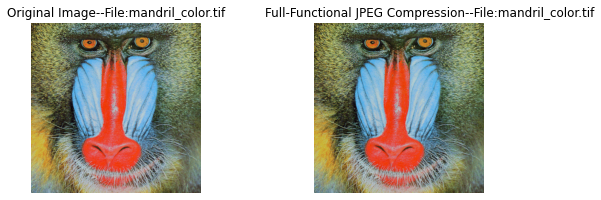

   
--------mandril_gray.tif_encoder_bitstream is done.--------


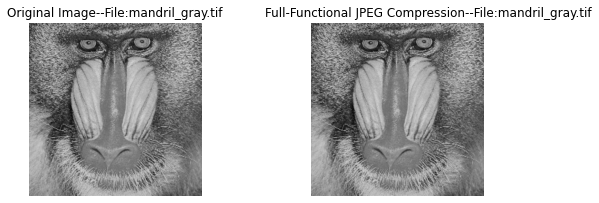

   
--------peppers_color.tif_encoder_bitstream is done.--------


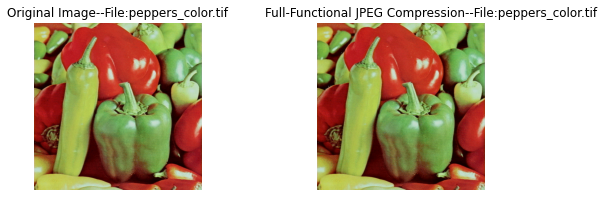

   
--------peppers_gray.tif_encoder_bitstream is done.--------


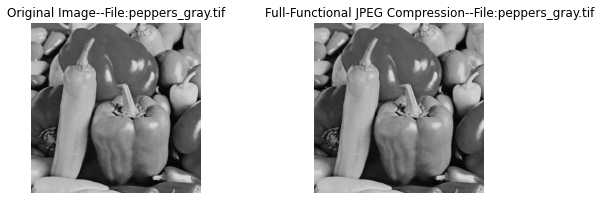

   
--------pirate.tif_encoder_bitstream is done.--------


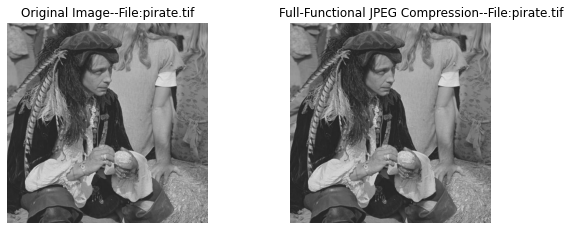

   
--------walkbridge.tif_encoder_bitstream is done.--------


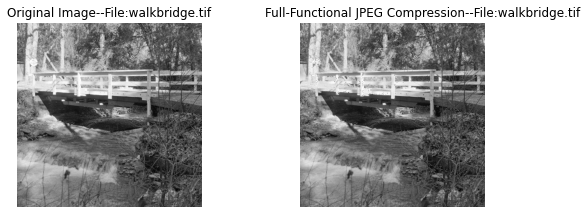

   
--------woman_blonde.tif_encoder_bitstream is done.--------


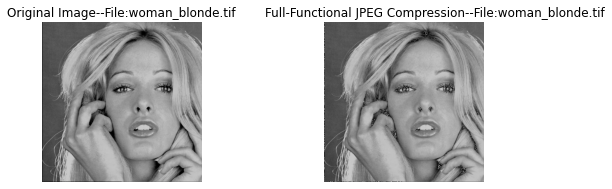

   
--------woman_darkhair.tif_encoder_bitstream is done.--------


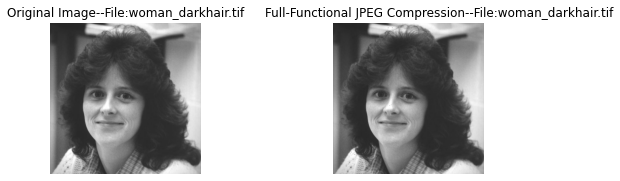

In [ ]:
import matplotlib

np.seterr(divide='ignore',invalid='ignore')

for name in ['cameraman.tif','house.tif','jetplane.tif', 'lake.tif', 'lena_color_512.tif', 'lena_gray_512.tif','livingroom.tif', 'mandril_color.tif', 'mandril_gray.tif','peppers_color.tif','peppers_gray.tif', 'pirate.tif', 'walkbridge.tif', 'woman_blonde.tif', 'woman_darkhair.tif']:
    matplotlib.rcParams['font.size'] = 10    
    # Read image
    im = np.array(Image.open('/{}'.format(name)).convert('RGB'), dtype = 'uint8')

    #Encoder
    encoder('/{}'.format(name),'/content/{}_encoder_bitstream'.format(name))
    print('--------{}_encoder_bitstream is done.--------'.format(name))
    
    # Decoder
    im2 = decoder('/content/'+str(name)+'_encoder_bitstream')
    
    # Specify the data type so that float value will be converted to int
    im2 = np.array(Image.open('/content/'+str(name)+'_decoder_bitstream.png'), dtype = 'uint8')
      
    fig, (ax1, ax2) = plt.subplots(nrows=1, 
                                        ncols=2, 
                                        figsize=(8, 5),
                                        sharex=True, 
                                        sharey=True)
    for aa in (ax1, ax2):
        aa.set_axis_off()
      
    # displaying images
    ax1.imshow(im)
    ax1.set_title('Original Image'+'--File:'+str(name))
    ax2.imshow(im2)
    ax2.set_title('                Full-Functional JPEG Compression'+'--File:'+str(name))
      
    plt.tight_layout()
    plt.show()

    print("   ")